# ⚙️ Configuración de desconocidos

Este cuaderno permite controlar si se incluyen en las tablas y gráficos las filas con valores desconocidos/no informados (por ejemplo, vendedores o categorías marcadas como "Desconocido").

- Cambia el valor de `SHOW_UNKNOWN` a `True` para incluirlos.
- Déjalo en `False` para filtrarlos en los análisis visuales/tabulares.


In [1]:
# Configuración de visualización
# Define si se incluyen filas con valores 'Desconocido'/'No informado' en tablas y gráficos.
# Puedes cambiarlo a True para incluirlos.
SHOW_UNKNOWN = False

In [2]:
# Utilidad: excluir valores desconocidos en columnas categóricas
from typing import Iterable, Optional
import pandas as pd

def exclude_unknown(df: pd.DataFrame, columns: Optional[Iterable[str]] = None) -> pd.DataFrame:
    """
    Devuelve un DataFrame sin filas cuyo valor en las columnas categóricas
    sea un marcador de desconocido/no informado o nulo.

    - columns: lista opcional de columnas a evaluar; si no se provee, se usan
      columnas preferidas si existen, y si no, todas las de tipo 'object'.
    """
    if df is None or len(df) == 0:
        return df

    # Marcadores comunes de desconocido/no informado
    unknowns = {
        'Desconocido', 'No informado', 'NO INFORMADO', 'DESCONOCIDO',
        'SIN ASIGNAR', 'SIN CLASIFICAR', 'UNKNOWN', 'N/A', 'NA', '-', ''
    }

    # Columnas preferidas típicas en este notebook
    preferred_cols = [
        'nombre_vendedor', 'apellido_vendedor', 'categoria_vendedor',
        'marca', 'modelo', 'metodo_pago', 'local_nombre', 'provincia',
        'cliente_categoria'
    ]

    if columns is None:
        cols = [c for c in preferred_cols if c in df.columns]
        if not cols:
            cols = df.select_dtypes(include=['object']).columns.tolist()
    else:
        cols = [c for c in columns if c in df.columns]

    if not cols:
        return df

    mask = pd.Series(True, index=df.index)
    for c in cols:
        # Mantener filas con valores válidos (no desconocidos y no nulos)
        m = df[c].notna() & (~df[c].isin(unknowns))
        mask &= m

    return df.loc[mask]

In [3]:
# Silenciar advertencias deprecadas de groupby.apply de pandas para una salida más limpia
import warnings
warnings.filterwarnings(
    "ignore",
    message="DataFrameGroupBy.apply operated on the grouping columns",
    category=DeprecationWarning,
)
print("⚙️ Filtro de warnings configurado (groupby.apply)")

⚙️ Filtro de warnings configurado (groupby.apply)


# 📊 Análisis de Data Warehouse - Ventas de Celulares
## Segundo Parcial - Modelado de Minería de Datos

---

### 🎯 Objetivo del Proyecto

Demostración de un **Data Warehouse completo** con:
- Esquema estrella dimensional
- ETL desde OLTP normalizado
- Slowly Changing Dimension Tipo 2 (SCD2)
- Análisis multidimensional con Python
- Visualizaciones de Business Intelligence

---

### 📂 Estructura del Análisis

1. **Configuración Inicial** (Celdas 1-5) — Filtros de desconocidos, imports, warnings
2. **Conexión al DW** (Celda 9) — SQLAlchemy + validación de drivers
3. **Carga de Dimensiones** (Celda 10) — Extracción de todas las dimensiones + FactVentas
4. **Validación de Datos** (Celda 11) — Verificar Unknown (SK=-1) y valores nulos
5. **Armado del Modelo Estrella** (Celda 14) — JOIN completo con todas las dimensiones
6. **Análisis SCD Tipo 2: Vendedores** (Celdas 16-17, 22-25) — Evolución temporal, heatmap, trayectorias ⭐
7. **Distribuciones Mensuales** (Celdas 19-21) — Histogramas, área apilada por categoría
8. **Consultas de Negocio** (Celdas 32-40) — Marca, vendedor, local, forma de pago, trimestres multimoneda 📊
9. **Conceptos DW** (Celda 41) — Kimball vs Inmon, Surrogate Keys, atomicidad

---

**Nota:** Datos sintéticos con fines académicos.

## Tabla de contenidos

1. **Conexión y carga de dimensiones** — Establecer base analítica del modelo estrella
2. **Armado del modelo estrella** — JOIN completo FactVentas + dimensiones
3. **Validación de integridad** — Verificar registros Unknown (SK=-1) y valores nulos
4. **SCD Tipo 2: Evolución de vendedores** — Líneas de tiempo, heatmap y categorización
5. **Consultas de negocio con Pandas** — Equivalencia Pandas ↔ SQL (marca, vendedor, local, forma pago, trimestres multimoneda)
6. **Distribuciones del mes seleccionado** — Histogramas, área apilada por categoría
7. **Análisis temporal** — Series de tiempo con ventas mensuales por categoría
8. **Conceptos de Data Warehousing** — Kimball vs Inmon, Surrogate Keys, Unknown values

**Tip:** Usa Buscar (Ctrl+F) con palabras clave como "SCD", "multimoneda", "heatmap", etc.

## 📦 1. Conexión y Carga de Dimensiones

### Propósito: Establecer la base analítica del modelo estrella

Este análisis requiere **acceso directo a las dimensiones del DW** para construir un modelo estrella completo en memoria. La razón de cargar cada dimensión por separado (en lugar de una vista materializada) es triple:

1. **Flexibilidad analítica**: Permite aplicar filtros y transformaciones específicas por dimensión antes del JOIN
2. **Validación de integridad**: Verificar que cada dimensión contenga registros Unknown (SK=-1) y que no haya valores nulos en surrogate keys
3. **Optimización de memoria**: Cargar solo las columnas necesarias para el análisis, reduciendo footprint en Pandas

La conexión mediante **SQLAlchemy** (en lugar de pyodbc directo) se justifica porque:
- Abstrae diferencias entre motores SQL
- Gestiona automáticamente el pool de conexiones
- Permite portabilidad futura (SQL Server → PostgreSQL/MySQL sin cambiar código)

In [4]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN INICIAL
# ============================================================

# Librerías estándar
import urllib.parse

# Librerías de análisis de datos
import pandas as pd
import numpy as np
import sqlalchemy as sa

# Librerías de visualización
try:
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap
    import seaborn as sns
    HAS_SEABORN = True
    # Configurar estilo de gráficos
    plt.style.use('default')
    sns.set_palette("husl")
except Exception:
    HAS_SEABORN = False

# pyodbc para SQL Server
try:
    import pyodbc
    HAS_PYODBC = True
except:
    HAS_PYODBC = False

# ============================================================
# CONFIGURACIÓN DE CONEXIÓN A SQL SERVER (opcional)
# ============================================================

SERVER = 'localhost'
DATABASE_DW = 'DW_Celulares'
TRUSTED_CONNECTION = True

# Intentar con múltiples drivers (de más moderno a más básico)
drivers_to_try = [
    'ODBC Driver 18 for SQL Server',
    'ODBC Driver 17 for SQL Server',
    'SQL Server Native Client 11.0',
    'SQL Server'
]

if HAS_PYODBC:
    available_drivers = pyodbc.drivers()
    print(f"Drivers ODBC disponibles: {available_drivers}\n")
    
    # Filtrar drivers disponibles
    drivers_to_try = [d for d in drivers_to_try if d in available_drivers]
    if not drivers_to_try:
        drivers_to_try = available_drivers  # Usar cualquier driver disponible

# Si RUN_SQL está desactivado, no intentes conectar
if 'RUN_SQL' in globals() and not RUN_SQL:
    print("⏭️ Conexión a SQL saltada (RUN_SQL=False). Usá las consultas de 05_consultas/ en otra herramienta si querés comparar.")
    engine = None

    def load_df(sql: str) -> pd.DataFrame:
        raise RuntimeError("RUN_SQL=False: load_df() deshabilitado en el notebook. Ejecuta la consulta en 05_consultas/ externamente.")
else:
    engine = None
    for DRIVER in drivers_to_try:
        try:
            print(f"Intentando con driver: {DRIVER}")
            params = urllib.parse.quote_plus(
                f"DRIVER={{{DRIVER}}};"
                f"SERVER={SERVER};"
                f"DATABASE={DATABASE_DW};"
                f"Trusted_Connection=yes;"
                f"TrustServerCertificate=yes;"
            )
            test_engine = sa.create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
            # Probar la conexión
            with test_engine.connect() as conn:
                conn.execute(sa.text("SELECT 1"))
            engine = test_engine
            print(f"✓ Conexión exitosa con: {DRIVER}\n")
            break
        except Exception as e:
            print(f"  ✗ Falló: {str(e)[:100]}")
            continue

    if engine is None:
        print("\n⚠️ ERROR: No se pudo conectar con ningún driver.")
        print("Verifica que:")
        print("  1. SQL Server esté corriendo")
        print("  2. La base DW_Celulares exista")
        print("  3. Tengas drivers ODBC instalados")
    else:
        def load_df(sql: str) -> pd.DataFrame:
            """Helper para ejecutar queries y retornar DataFrames"""
            return pd.read_sql_query(sa.text(sql), engine)
        
        print(f"SQLAlchemy version: {sa.__version__}")
        print("✓ Función load_df() lista para usar")


Drivers ODBC disponibles: ['SQL Server', 'SQL Server Native Client 11.0', 'ODBC Driver 17 for SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

Intentando con driver: ODBC Driver 17 for SQL Server
✓ Conexión exitosa con: ODBC Driver 17 for SQL Server

SQLAlchemy version: 2.0.44
✓ Función load_df() lista para usar


In [5]:
# Consultas para cada dimensión y la tabla de hechos (referencia)
queries = {
    'DimFecha': '''
        SELECT sk_fecha, fecha, anio, mes, trimestre, dia_semana, nombre_mes, es_fin_semana, numero_semana, dia_mes, dia_anio
        FROM dbo.DimFecha
    ''' ,
    'DimCliente': '''
        SELECT sk_cliente, id_cliente_fuente, nombre, apellido, genero
        FROM dbo.DimCliente
    ''',
    'DimProducto': '''
        SELECT sk_producto, id_modelo_fuente, marca, modelo, almacenamiento_gb, ram_gb
        FROM dbo.DimProducto
    ''' ,
    'DimLocal': '''
        SELECT sk_local, id_local_fuente, provincia, ciudad, local
        FROM dbo.DimLocal
    ''' ,
    'DimVendedor': '''
        SELECT sk_vendedor, id_vendedor_fuente, nombre, apellido, legajo, fecha_inicio, fecha_fin, es_actual, version, categoria_vendedor
        FROM dbo.DimVendedor
    ''' ,
    'DimFormaPago': '''
        SELECT sk_forma_pago, id_forma_pago_fuente, forma_pago
        FROM dbo.DimFormaPago
    ''' ,
    'DimCanal': '''
        SELECT sk_canal, canal, descripcion
        FROM dbo.DimCanal
    ''' ,
    'DimMoneda': '''
        SELECT sk_moneda, codigo_moneda, nombre AS nombre_moneda, simbolo AS simbolo_moneda, es_moneda_base
        FROM dbo.DimMoneda
    ''' ,
    'DimExchangeRate': '''
        SELECT e.sk_exchange, e.sk_moneda, e.fecha, e.codigo_moneda, e.tasa_ars_por_unidad, e.fuente,
               m.nombre AS nombre_moneda, m.simbolo AS simbolo_moneda
        FROM dbo.DimExchangeRate e
        JOIN dbo.DimMoneda m ON e.sk_moneda = m.sk_moneda
    ''' ,
    'FactVentas': '''
        SELECT id_venta, id_detalle, sk_fecha, sk_cliente, sk_producto, sk_local, sk_vendedor, sk_forma_pago, sk_canal, sk_moneda,
               cantidad, precio_unitario, costo_unitario, importe, margen, margen_porcentaje, tipo_cambio
        FROM dbo.FactVentas
    ''' ,
}

# Cargar DataFrames desde SQL solo si RUN_SQL=True
if 'RUN_SQL' in globals() and not RUN_SQL:
    print("⏭️ Carga de dimensiones desde SQL saltada (RUN_SQL=False).")
    if 'dfs' in globals():
        print("   → Usando DataFrames ya cargados en esta sesión.")
    else:
        print("   → Si necesitas empezar desde cero sin SQL, carga un dataset local o ejecuta las consultas manualmente.")
else:
    dfs = {k: load_df(v) for k, v in queries.items()}
    for name, df in dfs.items():
        print(f"{name}: {len(df):,} filas, columnas: {list(df.columns)[:6]}... (+{df.shape[1]-6} más)")


DimFecha: 4,018 filas, columnas: ['sk_fecha', 'fecha', 'anio', 'mes', 'trimestre', 'dia_semana']... (+5 más)
DimCliente: 201 filas, columnas: ['sk_cliente', 'id_cliente_fuente', 'nombre', 'apellido', 'genero']... (+-1 más)
DimProducto: 13 filas, columnas: ['sk_producto', 'id_modelo_fuente', 'marca', 'modelo', 'almacenamiento_gb', 'ram_gb']... (+0 más)
DimLocal: 13 filas, columnas: ['sk_local', 'id_local_fuente', 'provincia', 'ciudad', 'local']... (+-1 más)
DimVendedor: 16 filas, columnas: ['sk_vendedor', 'id_vendedor_fuente', 'nombre', 'apellido', 'legajo', 'fecha_inicio']... (+4 más)
DimFormaPago: 6 filas, columnas: ['sk_forma_pago', 'id_forma_pago_fuente', 'forma_pago']... (+-3 más)
DimCanal: 3 filas, columnas: ['sk_canal', 'canal', 'descripcion']... (+-3 más)
DimMoneda: 6 filas, columnas: ['sk_moneda', 'codigo_moneda', 'nombre_moneda', 'simbolo_moneda', 'es_moneda_base']... (+-1 más)
DimExchangeRate: 120 filas, columnas: ['sk_exchange', 'sk_moneda', 'fecha', 'codigo_moneda', 'tasa_a

In [6]:
# 🎨 Paleta de colores Splatoon
SPLATOON_COLORS = {
    'Top': '#5cd05b',        # Emerald Green - El mejor desempeño
    'Medio': '#fedc0c',      # Yellow Orange - Desempeño medio
    'Bajo': '#f78f2e',       # Orange - Desempeño bajo
    'SinVentas': '#fe447d',  # Pink - Sin actividad
    'extra1': '#448bff',     # Light Blue
    'extra2': '#6844E6',     # Purple
    'extra3': '#7af5ca',     # Sea Green
    'extra4': '#101ab3'      # Dark Blue
}

print("🎨 Paleta Splatoon configurada")

🎨 Paleta Splatoon configurada


## 🧱 Arquitectura de Monedas en el Data Warehouse

### **¿Por qué necesitamos dos tablas?**

El DW implementa un diseño **normalizado** para manejo multimoneda que separa:

1. **DimMoneda** (catálogo estático): Define qué monedas existen
   - `sk_moneda`: Surrogate key (PK)
   - `codigo`: USD, EUR, BRL, CNY (código ISO)
   - `nombre`: Dólar estadounidense, Euro, Real brasileño, Yuan chino
   - `simbolo`: $, €, R$, ¥
   - `es_base`: ¿Es la moneda base del negocio? (ARS = TRUE)

2. **DimExchangeRate** (datos históricos): Registra cotizaciones por fecha
   - `sk_exchange`: PK
   - `sk_moneda`: FK → DimMoneda (¿cuál moneda?)
   - `fecha`: ¿Cuándo cotizó?
   - `tasa_ars_por_unidad`: ¿Cuántos ARS vale 1 unidad de esta moneda?
   - `fuente`: seed-demo-ficticio (en producción: BCRA, API externa)

### **¿Cómo funciona?**

```
FactVentas (importe en ARS)
    ↓
    JOIN DimFecha (agrupar por mes/trimestre)
    ↓
    JOIN DimExchangeRate ON (fecha = mes_de_venta, sk_moneda = 'USD')
    ↓
    Calcular: importe_usd = importe_ars / tasa_ars_por_unidad
```

### **Ventajas de este diseño:**

✅ **Flexibilidad**: Agregar nuevas monedas sin modificar esquema  
✅ **Auditoría**: Historial completo de cotizaciones  
✅ **Precisión**: Usar la tasa exacta del día/mes de la venta  
✅ **Escalabilidad**: Separar catálogo (5 filas) de histórico (miles)

### **Limitaciones actuales (demo):**

⚠️ **Datos ficticios**: Las tasas son inventadas para propósitos académicos  
⚠️ **Granularidad mensual**: Una tasa promedio por mes (en producción: diaria)  
⚠️ **4 monedas**: Solo USD, EUR, BRL, CNY (expandible a cualquier otra)

## 🌟 2. Armado del Modelo Estrella

### Propósito: Desnormalización analítica para consultas eficientes

El modelo estrella se construye mediante **JOINs en Pandas** (en lugar de crear una vista SQL materializada) porque:

1. **Exploratory Data Analysis (EDA)**: Este notebook es un entorno de descubrimiento, no un reporte fijo. Necesitamos iterar con diferentes filtros y agregaciones sin impactar la base de datos
2. **Rendimiento local**: Pandas opera en memoria RAM, permitiendo transformaciones y pivoteos mucho más rápidos que ejecutar múltiples queries SQL
3. **Prototipado de métricas**: Facilita experimentar con nuevas métricas calculadas (ej: categorías de vendedores por quintiles) antes de implementarlas en ETL

**Dimensiones desnormalizadas (8 tablas → 1 DataFrame):**
- **DimFecha**: Añade contexto temporal (trimestre, nombre_mes) para análisis de estacionalidad
- **DimCliente**: Permite segmentación por perfil de comprador (futuro: RFM)
- **DimProducto**: Crucial para análisis de marca y modelo más vendido
- **DimLocal**: Geografía de ventas (local_ganancia por ubicación)
- **DimVendedor**: **SCD Tipo 2** — Razón principal de este análisis ⭐
- **DimFormaPago**: Identifica métodos de pago preferidos
- **DimCanal**: Junk dimension (Online/Presencial)
- **DimMoneda**: Soporte multi-moneda con símbolos Unicode correctos

In [7]:
dfecha = dfs['DimFecha']
dcli = dfs['DimCliente']
dprod = dfs['DimProducto']
dloc = dfs['DimLocal']
dvend = dfs['DimVendedor']
dfp = dfs['DimFormaPago']
dcanal = dfs['DimCanal']
dmon = dfs['DimMoneda']
fact = dfs['FactVentas']

# Selección y renombre para evitar colisiones de nombres (cliente vs vendedor)
dvend_sel = dvend[['sk_vendedor','id_vendedor_fuente','nombre','apellido','legajo','categoria_vendedor','fecha_inicio','fecha_fin','version']].rename(
    columns={'nombre':'nombre_vendedor','apellido':'apellido_vendedor','legajo':'legajo_vendedor'}
)

# Selección de columnas de producto (solo las necesarias)
dprod_sel = dprod[['sk_producto','marca','modelo','almacenamiento_gb','ram_gb']]

# Join por surrogate keys
star = (
    fact
    .merge(dfecha, on='sk_fecha', how='left')
    .merge(dvend_sel, on='sk_vendedor', how='left')
    .merge(dloc, on='sk_local', how='left')
    .merge(dprod_sel, on='sk_producto', how='left')
    .merge(dfp, on='sk_forma_pago', how='left')
    .merge(dcanal, on='sk_canal', how='left')
    .merge(dmon, on='sk_moneda', how='left')
    .merge(dcli, on='sk_cliente', how='left')
)

# Normalización de fecha mensual para análisis temporal
star['mes'] = pd.to_datetime(star['fecha']).dt.to_period('M').dt.to_timestamp()

# Mostrar información del modelo estrella
print(f"Registros en dataset estrella: {len(star):,}")
print(f"Columnas: {star.shape[1]}")
print(f"\nPrimeras 5 filas:")
display(star.head(5))

Registros en dataset estrella: 464
Columnas: 55

Primeras 5 filas:


,id_venta,id_detalle,sk_fecha,sk_cliente,sk_producto,sk_local,sk_vendedor,sk_forma_pago,sk_canal,sk_moneda,...,canal,descripcion,codigo_moneda,nombre_moneda,simbolo_moneda,es_moneda_base,id_cliente_fuente,nombre,apellido,genero
0,1,1,2065,100,6,11,5,1,1,1,...,Online,Venta por canal Online,ARS,Peso Argentino,$,True,100,Laura,Fernández,F
1,2,2,1765,11,1,11,8,1,2,1,...,Salón,Venta por canal Salón,ARS,Peso Argentino,$,True,11,Cintia,Martínez,X
2,2,3,1765,11,6,11,8,1,2,1,...,Salón,Venta por canal Salón,ARS,Peso Argentino,$,True,11,Cintia,Martínez,X
3,3,4,1476,146,2,6,4,3,2,1,...,Salón,Venta por canal Salón,ARS,Peso Argentino,$,True,146,Sergio,Martínez,M
4,3,5,1476,146,6,6,4,3,2,1,...,Salón,Venta por canal Salón,ARS,Peso Argentino,$,True,146,Sergio,Martínez,M


### 📋 Validación del Modelo Estrella

Verificamos que el JOIN generó correctamente el modelo dimensional con todas las métricas y atributos.

Resumen completo (primeras 10 filas):
         mes  id_vendedor_fuente nombre_vendedor apellido_vendedor  \
0 2024-01-01                   2           Lucía             Pérez   
1 2024-01-01                   4        Agustina         Rodríguez   
2 2024-01-01                   8           Lucía         Rodríguez   
3 2024-01-01                  14          Camila           Álvarez   
4 2024-01-01                  15           Bruno             Gómez   
8 2024-02-01                   8           Lucía         Rodríguez   
9 2024-02-01                   9           Sofía          Martínez   
5 2024-02-01                   1         Nicolás         Rodríguez   
6 2024-02-01                   3           Sofía          Martínez   
7 2024-02-01                   6           Mateo           Álvarez   

  categoria_vendedor  ventas  lineas  importe  
0               Bajo       2       2  1032.95  
1              Medio       2       5  4609.09  
2                Top       2       3  4830.43  

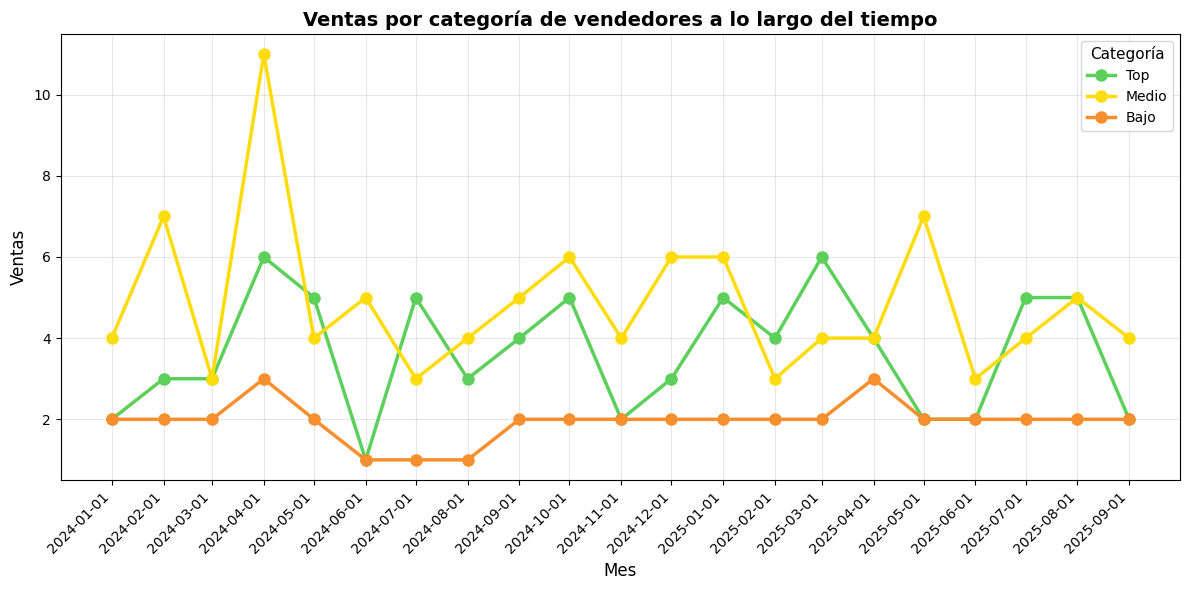


📋 Tabla resumen por mes y categoría:


categoria_vendedor,Bajo,Medio,Top
mes,,,
2024-01-01,2,4,2
2024-02-01,2,7,3
2024-03-01,2,3,3
2024-04-01,3,11,6
2024-05-01,2,4,5
2024-06-01,1,5,1
2024-07-01,1,3,5
2024-08-01,1,4,3
2024-09-01,2,5,4


In [8]:
# Vendedores y sus categorías a través del tiempo
cols = ['mes','id_vendedor_fuente','nombre_vendedor','apellido_vendedor','categoria_vendedor','id_venta','id_detalle','importe']

# Aplicar política de desconocidos en visualizaciones/tablas
base = star if SHOW_UNKNOWN else exclude_unknown(star)

# Si todas las filas están como 'Inicial' (sin clasificación real), derivar categorías en Pandas por mes
cats_existentes = set(base['categoria_vendedor'].dropna().unique().tolist()) - {'Inicial'}
if len(cats_existentes) == 0 and len(base) > 0:
    # Calcular facturación mensual por vendedor (solo vendedores reales, excluir id_vendedor_fuente=-1)
    tmp = (
        base[base['id_vendedor_fuente'] != -1]
        .groupby(['mes','id_vendedor_fuente','nombre_vendedor','apellido_vendedor'], as_index=False)
        .agg(importe=('importe','sum'))
    )
    # Para cada mes, asignar Top/Medio/Bajo según percentiles 80/20
    def asignar_cat(gr):
        if len(gr) == 0:
            return gr
        q20 = gr['importe'].quantile(0.20)
        q80 = gr['importe'].quantile(0.80)
        cat = np.where(gr['importe'] >= q80, 'Top', np.where(gr['importe'] < q20, 'Bajo', 'Medio'))
        gr = gr.copy()
        gr['categoria_vendedor'] = cat
        return gr
    
    tmp = tmp.groupby('mes', group_keys=False).apply(asignar_cat)
    
    # Reinyectar categorías a nivel de detalle (merge por mes+vendedor)
    base = base.drop(columns=['categoria_vendedor']).merge(
        tmp[['mes','id_vendedor_fuente','categoria_vendedor']],
        on=['mes','id_vendedor_fuente'], how='left'
    )
    # Mantener 'Inicial' solo para el vendedor desconocido (-1)
    base.loc[base['categoria_vendedor'].isna(), 'categoria_vendedor'] = 'Inicial'

vend_time = (
    base[cols]
    .groupby(['mes','id_vendedor_fuente','nombre_vendedor','apellido_vendedor','categoria_vendedor'], as_index=False)
    .agg(ventas=('id_venta','nunique'), lineas=('id_detalle','count'), importe=('importe','sum'))
    .sort_values(['mes','ventas'], ascending=[True, False])
)

print("Resumen completo (primeras 10 filas):")
print(vend_time.head(10))

# Filtrar vendedores reales (excluir el Unknown -1 con categoría "Inicial")
vend_time_real = vend_time[vend_time['categoria_vendedor'] != 'Inicial'].copy()
# Fallback: si aún no hay vendedores reales, usar todos
if len(vend_time_real) == 0:
    vend_time_real = vend_time.copy()

print(f"\n📊 Total registros: {len(vend_time)} | Vendedores reales: {len(vend_time_real)}")
print("\nDistribución de categorías (vendedores reales):")
print(vend_time_real['categoria_vendedor'].value_counts().sort_index())

if HAS_SEABORN and len(vend_time_real) > 0:
    # Preparar datos agregados por mes y categoría
    vend_agg = vend_time_real.groupby(['mes','categoria_vendedor'], as_index=False)['ventas'].sum()

    # Categorías presentes (incluye 'Inicial' si es lo único disponible)
    cats_present = vend_agg['categoria_vendedor'].dropna().unique().tolist()
    desired_order = ['Top', 'Medio', 'Bajo', 'SinVentas', 'Inicial']
    cats_ordered = [c for c in desired_order if c in cats_present] + [c for c in cats_present if c not in desired_order]

    # Etiquetas y colores (mapea 'Inicial' a nombre más claro)
    label_map = {
        'Top': 'Top', 'Medio': 'Medio', 'Bajo': 'Bajo', 'SinVentas': 'Sin Ventas', 'Inicial': 'Inicial / Unknown'
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    any_line = False
    for cat in cats_ordered:
        data_cat = vend_agg[vend_agg['categoria_vendedor'] == cat]
        if not data_cat.empty:
            any_line = True
            ax.plot(
                data_cat['mes'], data_cat['ventas'],
                marker='o', linewidth=2.5, markersize=8,
                label=label_map.get(cat, cat),
                color=SPLATOON_COLORS.get(cat, '#808080')
            )

    ax.set_title('Ventas por categoría de vendedores a lo largo del tiempo', fontsize=14, fontweight='bold')
    ax.set_xlabel('Mes', fontsize=12)
    ax.set_ylabel('Ventas', fontsize=12)

    # Ordenar eje X por mes si es de tipo fecha o string ISO
    try:
        x_vals = sorted(vend_agg['mes'].unique())
        ax.set_xticks(x_vals)
    except Exception:
        pass

    if any_line:
        ax.legend(title='Categoría', title_fontsize=11, fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Tabla resumen numérica
    print("\n📋 Tabla resumen por mes y categoría:")
    pivot_table = vend_agg.pivot(index='mes', columns='categoria_vendedor', values='ventas').fillna(0)
    display(pivot_table)
else:
    if len(vend_time_real) == 0:
        print('⚠️ No hay datos de vendedores reales (solo registro Unknown)')
    else:
        print('Seaborn no está instalado; mostrando tabla resumida por categoría y mes...')
        resumen = vend_time_real.groupby(['mes','categoria_vendedor'], as_index=False)['ventas'].sum().pivot(index='mes', columns='categoria_vendedor', values='ventas')
        display(resumen.head(12))

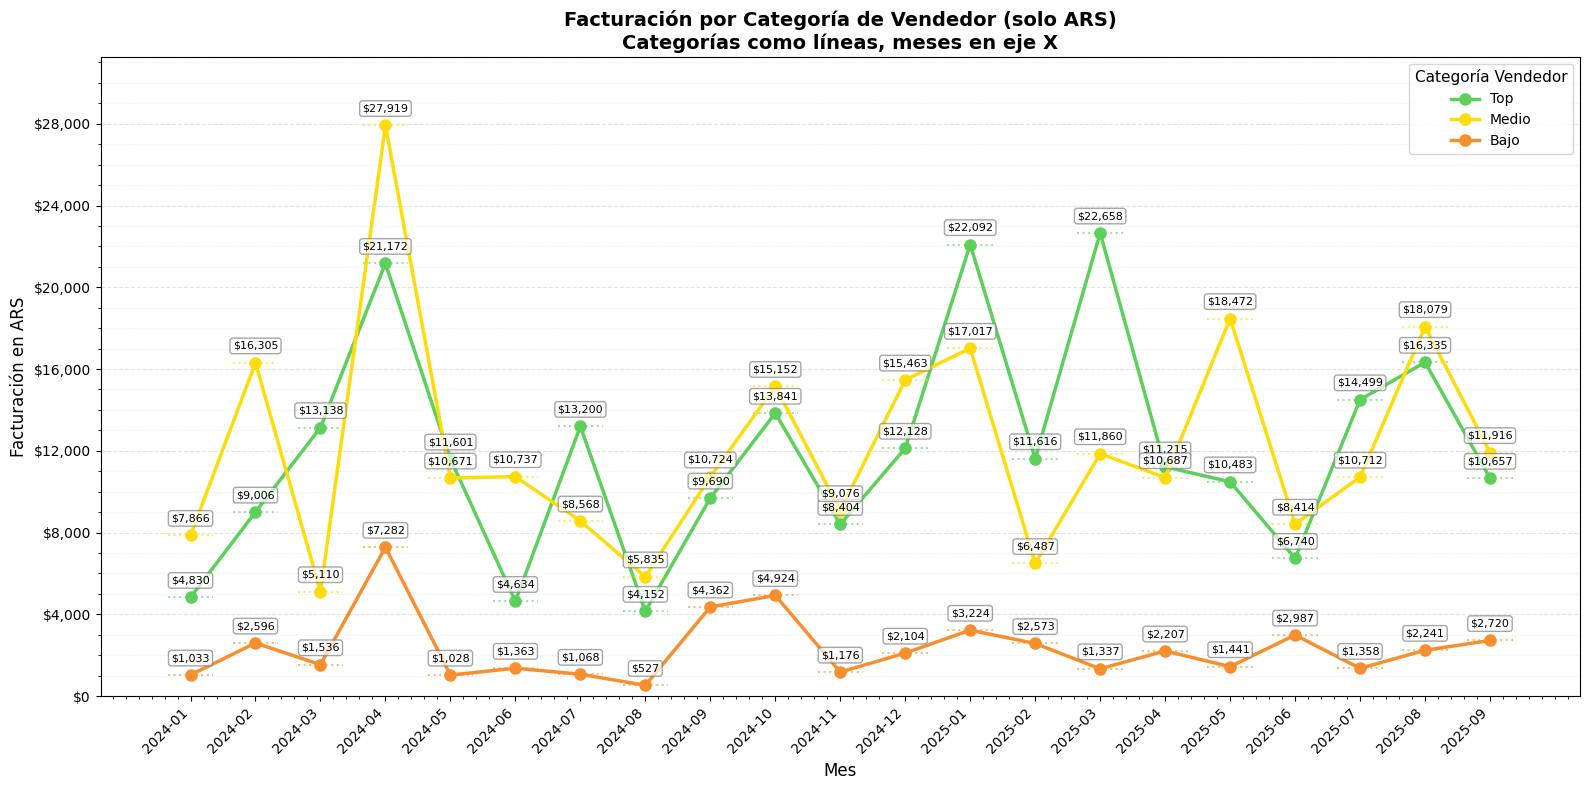

mes,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,...,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01
categoria_vendedor,,,,,,,,,,,,,,,,,,,,,
Top,4830.0,9006.0,13138.0,21172.0,11601.0,4634.0,13200.0,4152.0,9690.0,13841.0,...,12128.0,22092.0,11616.0,22658.0,11215.0,10483.0,6740.0,14499.0,16335.0,10657.0
Medio,7866.0,16305.0,5110.0,27919.0,10671.0,10737.0,8568.0,5835.0,10724.0,15152.0,...,15463.0,17017.0,6487.0,11860.0,10687.0,18472.0,8414.0,10712.0,18079.0,11916.0
Bajo,1033.0,2596.0,1536.0,7282.0,1028.0,1363.0,1068.0,527.0,4362.0,4924.0,...,2104.0,3224.0,2573.0,1337.0,2207.0,1441.0,2987.0,1358.0,2241.0,2720.0
Total,13730.0,27907.0,19785.0,56373.0,23300.0,16734.0,22836.0,10514.0,24776.0,33917.0,...,29695.0,42333.0,20676.0,35855.0,24110.0,30396.0,18141.0,26570.0,36655.0,25293.0


In [9]:
# Gráfico 1: Facturación por categoría de vendedor a lo largo del tiempo (solo ARS)
from matplotlib import ticker

# Usar datos reales si existen; si no, fallback al conjunto completo
base = vend_time_real if len(vend_time_real) > 0 else vend_time

if HAS_SEABORN and base is not None and len(base) > 0:
    # Crear identificador único para cada vendedor
    base = base.copy()
    base['vendedor_nombre'] = base['nombre_vendedor'] + ' ' + base['apellido_vendedor']
    
    # Agregar por categoría y mes (suma de importes en ARS)
    cat_mes = base.groupby(['mes', 'categoria_vendedor'], as_index=False).agg({
        'importe': 'sum'
    })
    
    # Guardar ARS y pivotear para líneas por categoría
    cat_mes['monto_ars'] = cat_mes['importe']
    pivot_data = cat_mes.pivot(index='categoria_vendedor', columns='mes', values='monto_ars')
    
    # Ordenar categorías: Top, Medio, Bajo, SinVentas (solo las presentes)
    cat_order = ['Top', 'Medio', 'Bajo', 'SinVentas']
    pivot_data = pivot_data.reindex([c for c in cat_order if c in pivot_data.index])

    # Si no hay datos para graficar, salir limpio
    if pivot_data.empty or pivot_data.size == 0 or pivot_data.isna().all().all():
        print("Sin datos para graficar categorías.")
    else:
        # Gráfico
        fig, ax = plt.subplots(figsize=(16, 8))
        
        # Plotear líneas por categoría con colores Splatoon
        for cat in pivot_data.index:
            x_vals = range(len(pivot_data.columns))
            y_vals = pivot_data.loc[cat].values
            
            ax.plot(x_vals, y_vals, marker='o', linewidth=2.5, markersize=8,
                    label=cat, color=SPLATOON_COLORS.get(cat, '#808080'))
            
            # Anotaciones con solo ARS y guías punteadas cortas en cada punto
            for x, y_ars in zip(x_vals, y_vals):
                if not pd.isna(y_ars):
                    # Etiqueta de valor (en miles si es grande)
                    label_val = f"${y_ars:,.0f}" if y_ars < 100000 else f"${y_ars/1000:,.0f}K"
                    ax.annotate(label_val,
                               xy=(x, y_ars),
                               xytext=(0, 10),
                               textcoords='offset points',
                               ha='center', fontsize=8,
                               bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.7, edgecolor='gray'))
                    # Segmento punteado horizontal alrededor del punto (para aproximar el valor)
                    ax.hlines(y=y_ars, xmin=x-0.35, xmax=x+0.35,
                              colors=SPLATOON_COLORS.get(cat, '#808080'), linestyles=':', linewidth=1.5, alpha=0.6)
        
        # Configuración del eje X con meses (labels legibles)
        ax.set_xticks(range(len(pivot_data.columns)))
        ax.set_xticklabels([col.strftime('%Y-%m') for col in pivot_data.columns], rotation=45, ha='right')
        
        # Título y ejes (solo ARS)
        ax.set_title('Facturación por Categoría de Vendedor (solo ARS)\nCategorías como líneas, meses en eje X',
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Mes', fontsize=12)
        ax.set_ylabel('Facturación en ARS', fontsize=12)
        
        # Más marcas en eje Y + formato pesos (robusto a NaN)
        y_vals_all = pivot_data.values.astype(float)
        y_max = np.nanmax(y_vals_all) if np.isfinite(np.nanmax(y_vals_all)) else 0.0
        if not np.isfinite(y_max) or y_max == 0:
            y_max = 1.0
        ax.set_ylim(0, y_max * 1.12)
        # Forzar más ticks (8–10)
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10, prune=None))
        # Formateador de pesos con separador de miles
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"${y:,.0f}"))
        # Activar grid principal y menor en Y con estilo punteado
        ax.minorticks_on()
        ax.grid(True, alpha=0.35, axis='y', linestyle='--', linewidth=0.8)
        ax.grid(which='minor', axis='y', linestyle=':', alpha=0.25)
        
        # Leyenda
        ax.legend(title='Categoría Vendedor', fontsize=10, title_fontsize=11, loc='best')
        
        plt.tight_layout()
        plt.show()
        
        # Tabla resumen (solo ARS)
        pivot_out = pivot_data.fillna(0).astype(float)
        pivot_out.loc['Total'] = pivot_out.sum(axis=0)
        display(pivot_out.round(0))
else:
    print("⚠️ Seaborn no disponible o no hay datos")

### 4.2 — Evolución Mensual: Aporte de Cada Categoría

**Propósito: Analizar composición del equipo de ventas en el tiempo**

Este gráfico de **área apilada** responde preguntas estratégicas que un gráfico de líneas superpuestas no puede:

1. **Proporción vs absoluto**: ¿Qué % del total mensual aporta cada categoría? Un gráfico de líneas muestra solo valores absolutos; el área apilada revela la **composición relativa**.

2. **Estabilidad del equipo**: ¿La proporción Top/Medio/Bajo se mantiene constante o varía mes a mes? Cambios bruscos indican rotación, capacitación exitosa o degradación del desempeño.

3. **Total mensual**: La **altura total** del área apilada muestra la facturación agregada de todo el equipo, permitiendo identificar meses pico y valles.

4. **Sin superposición**: A diferencia de gráficos de líneas con transparencia, las áreas apiladas **no se superponen**, facilitando lectura precisa de la contribución de cada categoría.

**Casos de uso:**
- Validar si capacitaciones aumentaron la proporción de vendedores Top
- Detectar si meses de alta facturación se deben a más vendedores activos o a mejor desempeño individual
- Identificar estacionalidad en la distribución de categorías (ej: ¿en diciembre todos mejoran?)

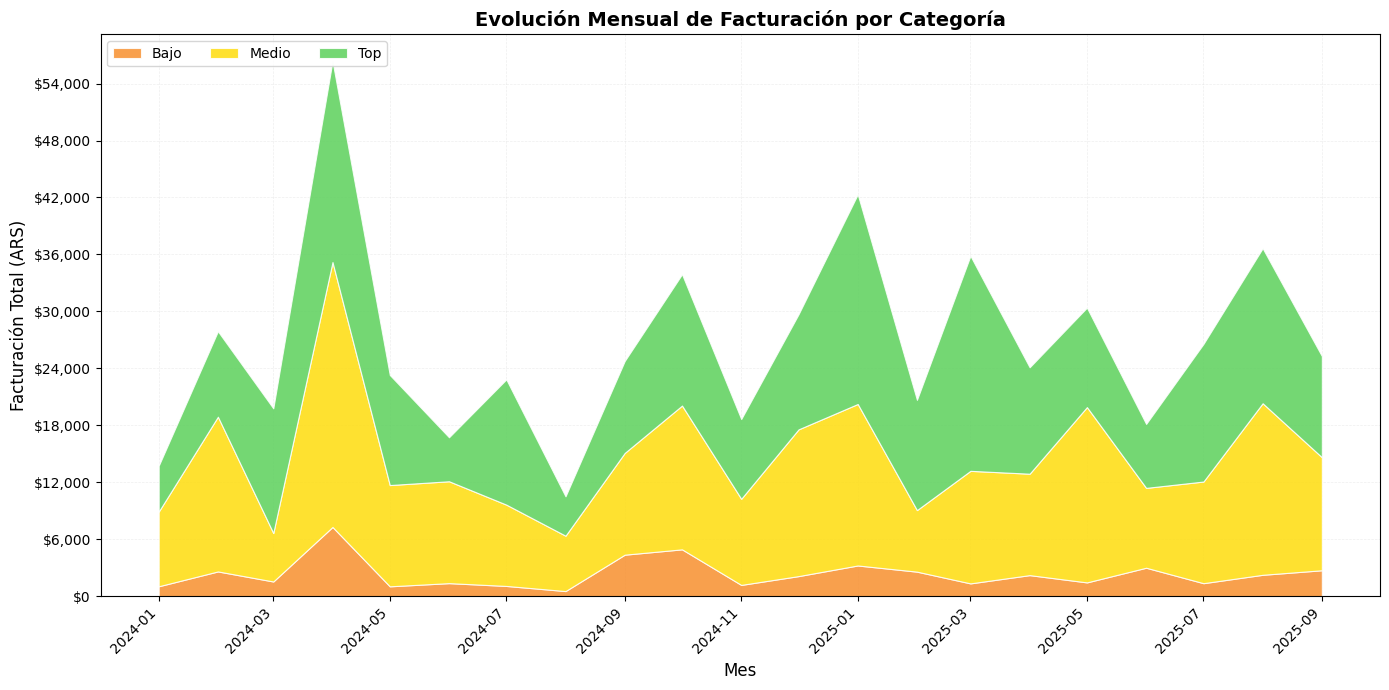

In [10]:
# GRÁFICO DE ÁREA APILADA: Evolución mensual por categoría de vendedor
from matplotlib import ticker

# Usar vend_time_real si tiene datos; si no, caer a vend_time
base = vend_time_real if len(vend_time_real) > 0 else vend_time

# Si no hay datos, salir sin error
if base is None or len(base) == 0:
    print("Sin datos para graficar área apilada.")
else:
    # Agrupar por mes y categoría (ARS)
    vend_area_agg = (
        base.groupby(['mes', 'categoria_vendedor'], as_index=False)
            .agg({'importe': 'sum'})
    )

    # Pivotar: columnas por categoría
    vend_area_pivot = vend_area_agg.pivot(index='mes', columns='categoria_vendedor', values='importe').fillna(0)

    # Orden preferido y categorías presentes
    cat_order_area = ['Bajo', 'Medio', 'Top']
    cats_present = [c for c in cat_order_area if c in vend_area_pivot.columns]

    # Si no hay ninguna de las categorías esperadas, no graficar
    if len(cats_present) == 0 or vend_area_pivot.empty:
        print("Sin datos suficientes para el área apilada.")
    else:
        vend_area_pivot = vend_area_pivot[cats_present].sort_index()

        # Colores según categorías presentes
        colors_area = [SPLATOON_COLORS.get(c, '#808080') for c in cats_present]

        # Gráfico
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.stackplot(
            vend_area_pivot.index,
            *[vend_area_pivot[c] for c in cats_present],
            labels=cats_present,
            colors=colors_area,
            alpha=0.85,
            edgecolor='white',
            linewidth=0.8
        )

        ax.set_title('Evolución Mensual de Facturación por Categoría', fontsize=14, fontweight='bold')
        ax.set_xlabel('Mes', fontsize=12)
        ax.set_ylabel('Facturación Total (ARS)', fontsize=12)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'${y:,.0f}'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
        ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)
        ax.legend(loc='upper left', ncol=min(3, len(cats_present)), frameon=True, fontsize=10)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## 4. SCD Tipo 2: Evolución de Vendedores

### Propósito: Analizar el desempeño temporal de vendedores

Este análisis requiere **SCD Tipo 2 en DimVendedor** porque:

1. **Historial de desempeño**: Los vendedores cambian de categoría (Top → Medio → Bajo) a lo largo del tiempo según su facturación mensual. SCD Tipo 2 permite rastrear estas transiciones sin perder datos históricos.

2. **Análisis causal**: ¿Un vendedor que cae de Top a Bajo luego se recupera? ¿O permanece bajo? Esto revela patrones de retención y productividad que SCD Tipo 1 (sobrescritura) perdería para siempre.

3. **Ventajas del versionado temporal:**
   - **fecha_inicio/fecha_fin**: Define el período de vigencia de cada categoría
   - **version**: Identifica cuántas veces cambió un vendedor de categoría
   - **es_actual**: Permite filtrar el estado actual sin perder histórico

4. **Métrica de categorización**: Las categorías se calculan mediante `NTILE(5)` por facturación mensual en USD:
   - **Top**: Quintil superior (percentil 80-100)
   - **Medio**: Quintiles 2-4 (percentil 20-80)
   - **Bajo**: Quintil inferior (percentil 0-20)

El análisis que sigue responde preguntas clave de negocio:
- 4.1: **Evolución por categoría** — ¿Creció la facturación de los Top en el tiempo?
- 4.2: **Aporte mensual apilado** — ¿Qué proporción del total aporta cada categoría?
- 4.3: **Distribución total** — ¿Cómo se distribuye la facturación acumulada entre vendedores?
- 4.4: **Análisis mensual detallado** — ¿Qué vendedores están activos en un mes específico?
- 4.5: **Distribución estadística** — ¿La facturación sigue una curva normal o hay sesgos?

### 4.3 — Distribución Acumulada Total por Vendedor

**Propósito: Visualizar desigualdad en facturación global**

Este gráfico muestra la distribución de facturación **total acumulada** (no mensual) para identificar:

1. **Principio de Pareto (80/20)**: ¿El 20% de vendedores genera el 80% de las ventas? Las líneas de quintil (P20, P40, P60, P80) permiten validar esta hipótesis.

2. **Inequidad estructural**: La altura relativa de las barras revela si existe concentración extrema (pocos vendedores Top facturan mucho más que el resto).

3. **Cortes operativos**: Los quintiles son criterios objetivos para:
   - Bonificaciones/comisiones diferenciadas
   - Programas de capacitación (enfocar en Bajo/Medio)
   - Identificar outliers (vendedores excepcionales o problemáticos)

**Diseño del gráfico:**
- **Eje X**: Vendedores ordenados por facturación total ascendente (izquierda = menor, derecha = mayor)
- **Eje Y**: Monto total facturado en **ARS** (no USD) para legibilidad local
- **Colores**: Categorías asignadas por quintiles sobre esta facturación total
- **Líneas horizontales**: Umbrales de quintil (P20, P40, P60, P80) — marcan cortes exactos

**¿Por qué ARS aquí y USD en SCD2?**
- SCD2 mensual usa USD para neutralizar inflación entre meses
- Este gráfico acumulado total usa ARS porque muestra un snapshot sin comparaciones temporales, priorizando interpretabilidad para audiencia argentina

DISTRIBUCIÓN DE FACTURACIÓN POR VENDEDOR (QUINTILES) - ARS


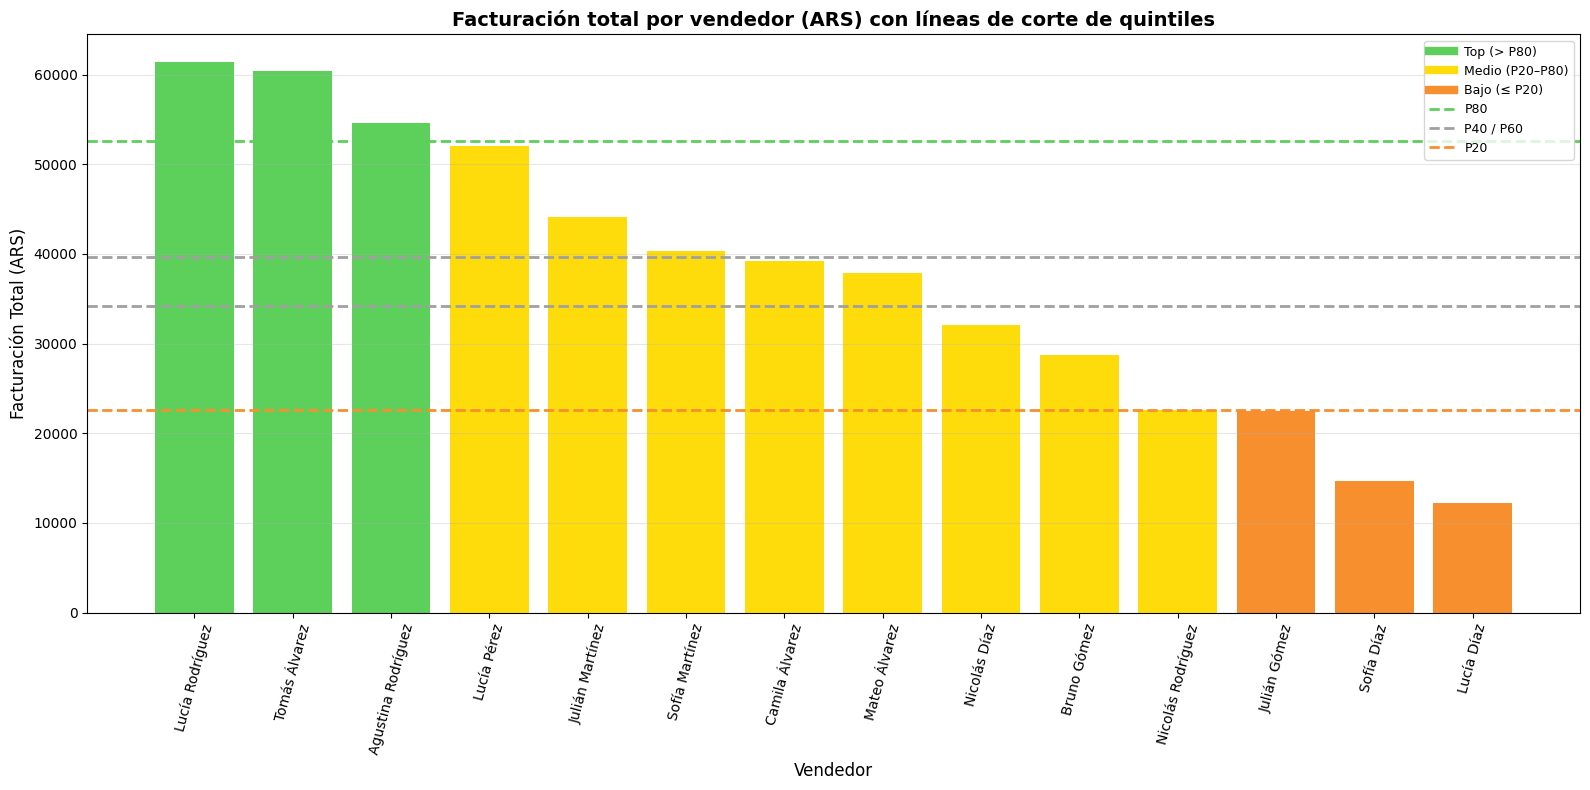

Vendedores totales: 15 | Mostrando: 15
Quintiles (ARS): P20=22,549, P40=34,220, P60=39,638, P80=52,552
Distribución por categoría (según ARS total):
categoria_por_ars
Top      3
Medio    9
Bajo     3
Name: count, dtype: int64


In [11]:
# 📊 Distribución de Facturación por Vendedor (Quintiles) en ARS
print("="*70)
print("DISTRIBUCIÓN DE FACTURACIÓN POR VENDEDOR (QUINTILES) - ARS")
print("="*70)

# Usar el dataset base respetando la política de Unknowns
base_plot = star if SHOW_UNKNOWN else exclude_unknown(star)

# Construir nombre legible del vendedor y excluir Unknown si aparece
plot_tmp = base_plot.copy()
plot_tmp['vendedor_nombre'] = plot_tmp['nombre_vendedor'].astype(str) + ' ' + plot_tmp['apellido_vendedor'].astype(str)
if 'id_vendedor_fuente' in plot_tmp.columns:
    plot_tmp = plot_tmp[plot_tmp['id_vendedor_fuente'] != -1]

# Agregar facturación total en ARS por vendedor
facturacion_vendedor = (
    plot_tmp
    .groupby(['id_vendedor_fuente','vendedor_nombre'], as_index=False)['importe']
    .sum()
    .rename(columns={'importe':'facturacion_total_ars'})
)

if len(facturacion_vendedor) == 0:
    print("⚠️ No hay datos de vendedores para graficar.")
else:
    # Quintiles (20/40/60/80) sobre ARS
    q20 = facturacion_vendedor['facturacion_total_ars'].quantile(0.20)
    q40 = facturacion_vendedor['facturacion_total_ars'].quantile(0.40)
    q60 = facturacion_vendedor['facturacion_total_ars'].quantile(0.60)
    q80 = facturacion_vendedor['facturacion_total_ars'].quantile(0.80)

    # Categoría por ARS total (3 categorías usando los cortes principales P20 y P80)
    def categoria_por_ars(v):
        if v <= q20:
            return 'Bajo'
        elif v > q80:
            return 'Top'
        else:
            return 'Medio'

    facturacion_vendedor['categoria_por_ars'] = facturacion_vendedor['facturacion_total_ars'].apply(categoria_por_ars)

    # Ordenar y limitar para legibilidad
    facturacion_vendedor = facturacion_vendedor.sort_values('facturacion_total_ars', ascending=False)
    TOP_N_LIMIT = 40
    total_vendedores = len(facturacion_vendedor)
    plot_df = facturacion_vendedor.head(TOP_N_LIMIT) if total_vendedores > TOP_N_LIMIT else facturacion_vendedor

    if HAS_SEABORN and len(plot_df) > 0:
        fig, ax = plt.subplots(figsize=(16, 8))

        # Barras coloreadas por categoría (paleta Splatoon)
        bar_colors = plot_df['categoria_por_ars'].map(lambda c: SPLATOON_COLORS.get(c, '#808080'))
        ax.bar(plot_df['vendedor_nombre'], plot_df['facturacion_total_ars'], color=bar_colors)

        ax.set_title('Facturación total por vendedor (ARS) con líneas de corte de quintiles', fontsize=14, fontweight='bold')
        ax.set_xlabel('Vendedor', fontsize=12)
        ax.set_ylabel('Facturación Total (ARS)', fontsize=12)
        ax.tick_params(axis='x', rotation=75)
        ax.grid(True, axis='y', alpha=0.3)

        # Líneas horizontales para P20, P40, P60, P80
        for y, label, col in [
            (q20, 'P20', SPLATOON_COLORS['Bajo']),
            (q40, 'P40', '#A0A0A0'),
            (q60, 'P60', '#A0A0A0'),
            (q80, 'P80', SPLATOON_COLORS['Top'])
        ]:
            ax.axhline(y, color=col, linestyle='--', linewidth=2, label=label)

        # Leyenda de categorías y líneas de quintil
        from matplotlib.lines import Line2D
        legend_elems = [
            Line2D([0],[0], color=SPLATOON_COLORS['Top'], lw=6, label='Top (> P80)'),
            Line2D([0],[0], color=SPLATOON_COLORS['Medio'], lw=6, label='Medio (P20–P80)'),
            Line2D([0],[0], color=SPLATOON_COLORS['Bajo'], lw=6, label='Bajo (≤ P20)'),
            Line2D([0],[0], color=SPLATOON_COLORS['Top'], lw=2, ls='--', label='P80'),
            Line2D([0],[0], color='#A0A0A0', lw=2, ls='--', label='P40 / P60'),
            Line2D([0],[0], color=SPLATOON_COLORS['Bajo'], lw=2, ls='--', label='P20'),
        ]
        ax.legend(handles=legend_elems, loc='upper right', fontsize=9)

        plt.tight_layout()
        plt.show()

        # Resumen textual
        print(f"Vendedores totales: {total_vendedores} | Mostrando: {len(plot_df)}")
        print(f"Quintiles (ARS): P20={q20:,.0f}, P40={q40:,.0f}, P60={q60:,.0f}, P80={q80:,.0f}")
        print("Distribución por categoría (según ARS total):")
        print(facturacion_vendedor['categoria_por_ars'].value_counts().reindex(['Top','Medio','Bajo']).fillna(0).astype(int))
    else:
        print("⚠️ Seaborn no disponible; mostrando tabla de ejemplo.")
        display(facturacion_vendedor.head(10))

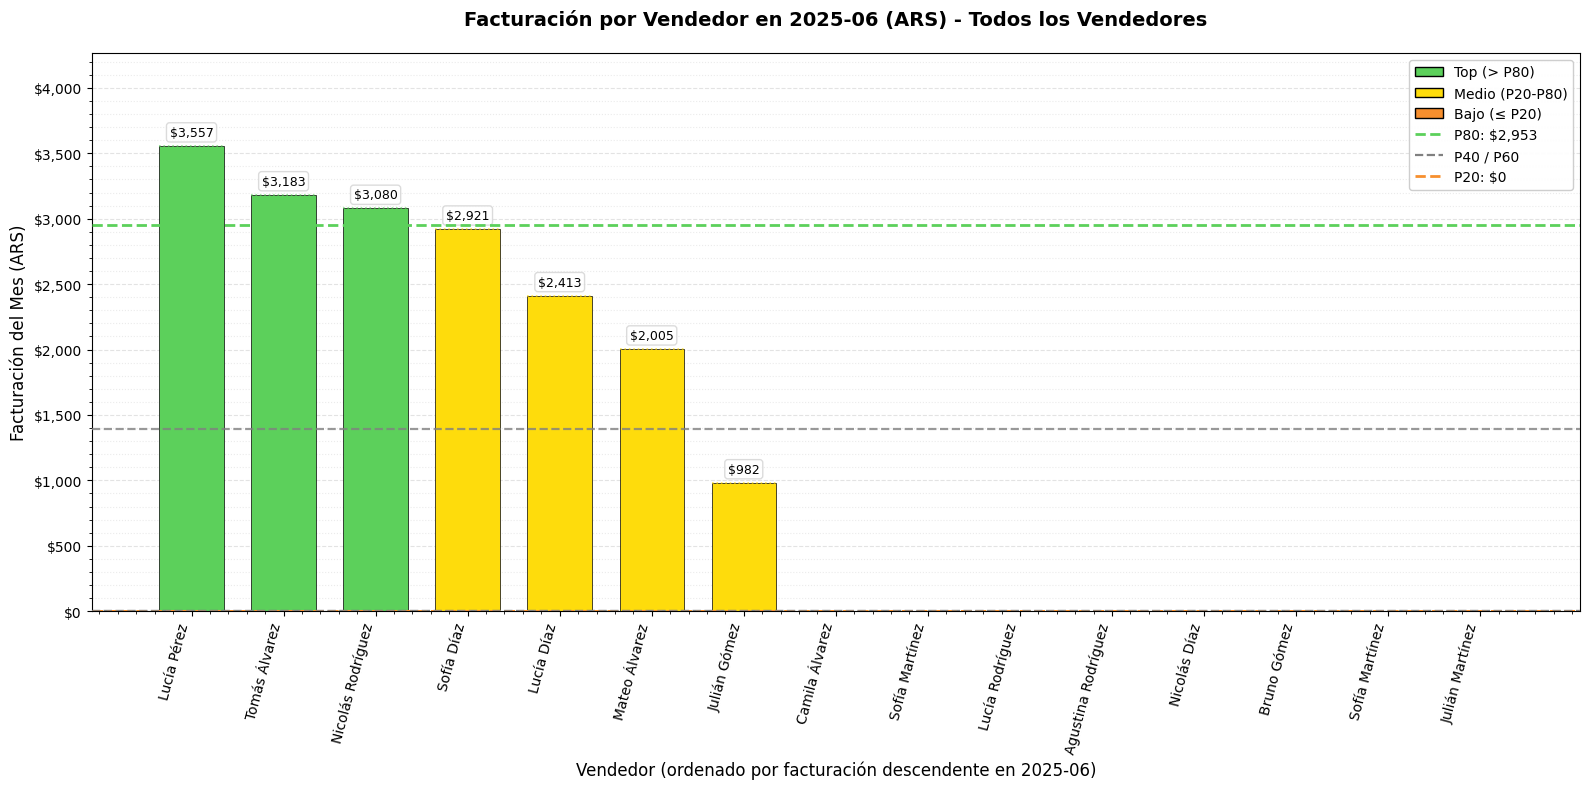


📊 Mes analizado: 2025-06
Vendedores totales: 15 (7 activos, 8 sin ventas)
Quintiles (ARS del mes): P20=$0 | P40=$0 | P60=$1,391 | P80=$2,953

Distribución por categoría en este mes:
categoria_mes
Top      3
Medio    4
Bajo     8
Name: count, dtype: int64

💡 Para cambiar el mes, modifica la variable MES_SELECCIONADO en la línea 6
   Formato: 'YYYY-MM' (ejemplo: '2024-01', '2025-09')
   Ahora muestra TODOS los vendedores (los sin ventas aparecen con $0)


In [12]:
# 🔵 Gráfico de barras: Facturación por vendedor en un mes específico (TODOS los vendedores)
import numpy as np
from matplotlib import ticker

# ============================================================
# 🔧 CONFIGURACIÓN: Cambia este valor para ver otro mes
# ============================================================
MES_SELECCIONADO = '2025-06'  # Formato: 'YYYY-MM' (ej: '2024-01', '2025-09')
# ============================================================

# Dataset base respetando Unknowns
base_plot = star if SHOW_UNKNOWN else exclude_unknown(star)

tmp = base_plot.copy()
tmp['vendedor_nombre'] = tmp['nombre_vendedor'].astype(str) + ' ' + tmp['apellido_vendedor'].astype(str)
if 'id_vendedor_fuente' in tmp.columns:
    tmp = tmp[tmp['id_vendedor_fuente'] != -1]

# Obtener lista de TODOS los vendedores únicos (de todo el dataset)
todos_vendedores = tmp[['id_vendedor_fuente','vendedor_nombre']].drop_duplicates()

# Filtrar por el mes seleccionado
tmp_mes = tmp[tmp['mes'] == MES_SELECCIONADO].copy()

if len(todos_vendedores) == 0:
    print("⚠️ No hay vendedores en el dataset")
else:
    # Agregar facturación por vendedor en ese mes
    fv_mes = (
        tmp_mes
        .groupby(['id_vendedor_fuente','vendedor_nombre'], as_index=False)['importe']
        .sum()
        .rename(columns={'importe':'facturacion_mes_ars'})
    )
    
    # Hacer LEFT JOIN para incluir TODOS los vendedores (con 0 si no vendieron en el mes)
    fv = todos_vendedores.merge(fv_mes, on=['id_vendedor_fuente','vendedor_nombre'], how='left')
    fv['facturacion_mes_ars'] = fv['facturacion_mes_ars'].fillna(0)
    
    # Ordenar descendente por facturación del mes
    fv = fv.sort_values('facturacion_mes_ars', ascending=False).reset_index(drop=True)
    
    # Quintiles basados en la facturación del mes (de TODOS los vendedores incluyendo 0s)
    q20 = fv['facturacion_mes_ars'].quantile(0.20)
    q40 = fv['facturacion_mes_ars'].quantile(0.40)
    q60 = fv['facturacion_mes_ars'].quantile(0.60)
    q80 = fv['facturacion_mes_ars'].quantile(0.80)

    # Asignar categoría por quintiles
    def categoria_por_mes(v):
        if v <= q20:
            return 'Bajo'
        elif v > q80:
            return 'Top'
        else:
            return 'Medio'

    fv['categoria_mes'] = fv['facturacion_mes_ars'].apply(categoria_por_mes)

    # Colores por categoría
    bar_colors = fv['categoria_mes'].map(lambda c: SPLATOON_COLORS.get(c, '#808080'))

    # Crear gráfico
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Barras verticales
    bars = ax.bar(range(len(fv)), fv['facturacion_mes_ars'], color=bar_colors, width=0.7, edgecolor='black', linewidth=0.5)
    
    # Etiquetas numéricas y guías punteadas por barra (solo valores > 0)
    for i, (val, col) in enumerate(zip(fv['facturacion_mes_ars'], bar_colors)):
        if val > 0:
            ax.text(i, val + (0.015 * max(1, fv['facturacion_mes_ars'].max())), f"${val:,.0f}",
                    ha='center', va='bottom', fontsize=9, rotation=0,
                    bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8, edgecolor='lightgray'))
            ax.hlines(y=val, xmin=i-0.35, xmax=i+0.35, colors=col, linestyles=':', linewidth=1.2, alpha=0.7)
    
    # Líneas horizontales de quintiles
    ax.axhline(q20, color=SPLATOON_COLORS['Bajo'], linestyle='--', linewidth=2.0, label=f'P20 (Bajo): ${q20:,.0f}', zorder=5)
    ax.axhline(q40, color='#808080', linestyle='--', linewidth=1.6, label=f'P40: ${q40:,.0f}', alpha=0.8, zorder=5)
    ax.axhline(q60, color='#808080', linestyle='--', linewidth=1.6, label=f'P60: ${q60:,.0f}', alpha=0.8, zorder=5)
    ax.axhline(q80, color=SPLATOON_COLORS['Top'], linestyle='--', linewidth=2.0, label=f'P80 (Top): ${q80:,.0f}', zorder=5)
    
    # Etiquetas del eje X (vendedores)
    ax.set_xticks(range(len(fv)))
    ax.set_xticklabels(fv['vendedor_nombre'], rotation=75, ha='right')
    
    # Títulos y etiquetas
    ax.set_title(f'Facturación por Vendedor en {MES_SELECCIONADO} (ARS) - Todos los Vendedores', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel(f'Vendedor (ordenado por facturación descendente en {MES_SELECCIONADO})', fontsize=12)
    ax.set_ylabel('Facturación del Mes (ARS)', fontsize=12)

    # Más marcas en eje Y + formato pesos
    y_max = float(fv['facturacion_mes_ars'].max())
    ax.set_ylim(0, y_max * 1.2 if y_max > 0 else 1)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"${y:,.0f}"))
    ax.minorticks_on()
    ax.grid(which='major', axis='y', alpha=0.35, linestyle='--', linewidth=0.8)
    ax.grid(which='minor', axis='y', linestyle=':', alpha=0.25)
    ax.set_axisbelow(True)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=SPLATOON_COLORS['Top'], edgecolor='black', label='Top (> P80)'),
        Patch(facecolor=SPLATOON_COLORS['Medio'], edgecolor='black', label='Medio (P20-P80)'),
        Patch(facecolor=SPLATOON_COLORS['Bajo'], edgecolor='black', label='Bajo (≤ P20)'),
        ax.axhline(0, color=SPLATOON_COLORS['Top'], linestyle='--', linewidth=2.0, label=f'P80: ${q80:,.0f}'),
        ax.axhline(0, color='#808080', linestyle='--', linewidth=1.6, label='P40 / P60'),
        ax.axhline(0, color=SPLATOON_COLORS['Bajo'], linestyle='--', linewidth=2.0, label=f'P20: ${q20:,.0f}'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, framealpha=0.95)
    
    plt.tight_layout()
    plt.show()
    
    # Resumen textual
    vendedores_activos = (fv['facturacion_mes_ars'] > 0).sum()
    vendedores_inactivos = (fv['facturacion_mes_ars'] == 0).sum()
    
    print(f"\n📊 Mes analizado: {MES_SELECCIONADO}")
    print(f"Vendedores totales: {len(fv)} ({vendedores_activos} activos, {vendedores_inactivos} sin ventas)")
    print(f"Quintiles (ARS del mes): P20=${q20:,.0f} | P40=${q40:,.0f} | P60=${q60:,.0f} | P80=${q80:,.0f}")
    print("\nDistribución por categoría en este mes:")
    print(fv['categoria_mes'].value_counts().reindex(['Top','Medio','Bajo']).fillna(0).astype(int))
    print(f"\n💡 Para cambiar el mes, modifica la variable MES_SELECCIONADO en la línea 6")
    print(f"   Formato: 'YYYY-MM' (ejemplo: '2024-01', '2025-09')")
    print(f"   Ahora muestra TODOS los vendedores (los sin ventas aparecen con $0)")

### 📊 Histograma con Distribución Normal (mes específico)

Visualización de distribución estadística para un mes seleccionado:
- **Barras naranjas**: Histograma de frecuencias (cantidad de vendedores por rango de facturación en el mes)
- **Curva azul**: Distribución normal teórica ajustada a los datos del mes
- **Líneas verticales punteadas**: P20, P40, P60, P80 (cortes de quintiles del mes)
- **Zonas sombreadas**: Bajo (naranja), Medio (amarillo), Top (verde)
- **Eje X**: Rangos de facturación en ARS del mes

**🔧 CONFIGURACIÓN**: Cambia la variable `MES_SELECCIONADO_DIST` en la celda siguiente para analizar otro periodo.

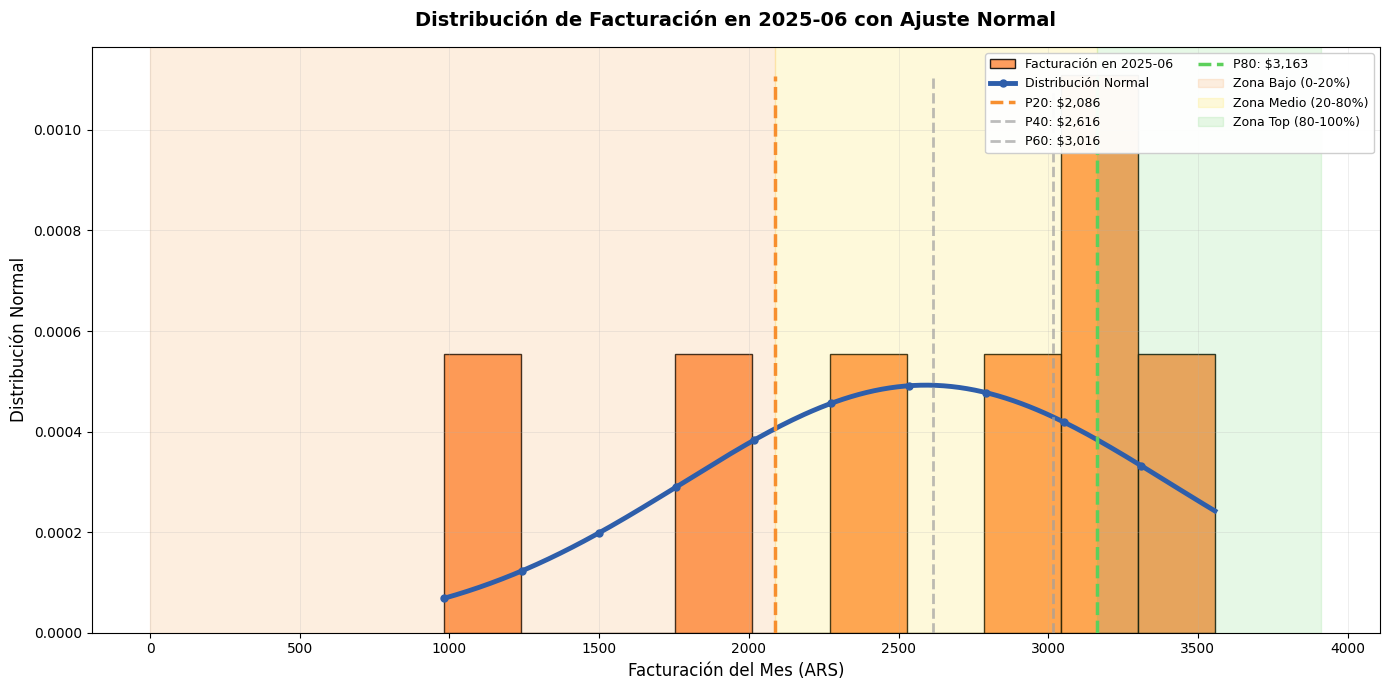


📊 Mes analizado: 2025-06
Vendedores activos: 7

Estadísticas de la distribución:
   Media (μ): $2,591.52
   Desviación estándar (σ): $810.33
   Mínimo: $981.94
   Máximo: $3,556.83

Quintiles del mes:
   P20 (Bajo): $2,086.29
   P40: $2,616.12
   P60: $3,016.47
   P80 (Top): $3,162.59

💡 La curva azul representa la distribución normal teórica ajustada a los datos del mes.
   Las líneas verticales punteadas marcan los cortes de quintiles (P20, P40, P60, P80).
   Para cambiar el mes, modifica la variable MES_SELECCIONADO_DIST


In [13]:
# 📊 Histograma con curva de distribución normal para un mes específico
import numpy as np
from scipy.stats import norm

# ============================================================
# 🔧 CONFIGURACIÓN: Cambia este valor para ver otro mes
# ============================================================
MES_SELECCIONADO_DIST = '2025-06'  # Formato: 'YYYY-MM' (ej: '2024-01', '2025-09')
# ============================================================

# Dataset base respetando Unknowns
base_plot = star if SHOW_UNKNOWN else exclude_unknown(star)

tmp = base_plot.copy()
tmp['vendedor_nombre'] = tmp['nombre_vendedor'].astype(str) + ' ' + tmp['apellido_vendedor'].astype(str)
if 'id_vendedor_fuente' in tmp.columns:
    tmp = tmp[tmp['id_vendedor_fuente'] != -1]

# Filtrar por el mes seleccionado
tmp_mes = tmp[tmp['mes'] == MES_SELECCIONADO_DIST].copy()

if len(tmp_mes) == 0:
    print(f"⚠️ No hay datos para el mes {MES_SELECCIONADO_DIST}")
    print(f"\nMeses disponibles: {sorted(tmp['mes'].unique())}")
else:
    # Agregar facturación por vendedor en ese mes
    fv = (
        tmp_mes
        .groupby(['id_vendedor_fuente','vendedor_nombre'], as_index=False)['importe']
        .sum()
        .rename(columns={'importe':'facturacion_mes_ars'})
    )
    
    # Datos de facturación del mes
    data = fv['facturacion_mes_ars'].values
    
    # Quintiles para líneas de corte
    q20 = np.percentile(data, 20)
    q40 = np.percentile(data, 40)
    q60 = np.percentile(data, 60)
    q80 = np.percentile(data, 80)
    
    # Parámetros de la distribución normal ajustada
    mu = data.mean()
    sigma = data.std()
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Histograma con barras naranjas
    n, bins, patches = ax.hist(data, bins=10, density=True, color='#FF8C42', 
                                edgecolor='black', alpha=0.85, label=f'Facturación en {MES_SELECCIONADO_DIST}')
    
    # Curva de distribución normal (azul)
    x_curve = np.linspace(data.min(), data.max(), 200)
    y_curve = norm.pdf(x_curve, mu, sigma)
    ax.plot(x_curve, y_curve, color='#2E5EAA', linewidth=3.5, 
            label='Distribución Normal', marker='o', markersize=5, markevery=20)
    
    # Líneas verticales de quintiles (guías de corte)
    y_max = ax.get_ylim()[1]
    ax.axvline(q20, color=SPLATOON_COLORS['Bajo'], linestyle='--', linewidth=2.5, 
               label=f'P20: ${q20:,.0f}', ymin=0, ymax=0.95, zorder=5)
    ax.axvline(q40, color='#A0A0A0', linestyle='--', linewidth=2, 
               label=f'P40: ${q40:,.0f}', ymin=0, ymax=0.95, alpha=0.7, zorder=5)
    ax.axvline(q60, color='#A0A0A0', linestyle='--', linewidth=2, 
               label=f'P60: ${q60:,.0f}', ymin=0, ymax=0.95, alpha=0.7, zorder=5)
    ax.axvline(q80, color=SPLATOON_COLORS['Top'], linestyle='--', linewidth=2.5, 
               label=f'P80: ${q80:,.0f}', ymin=0, ymax=0.95, zorder=5)
    
    # Sombreado de zonas (fondo)
    ax.axvspan(0, q20, alpha=0.15, color=SPLATOON_COLORS['Bajo'], label='Zona Bajo (0-20%)', zorder=1)
    ax.axvspan(q20, q80, alpha=0.15, color=SPLATOON_COLORS['Medio'], label='Zona Medio (20-80%)', zorder=1)
    ax.axvspan(q80, data.max()*1.1, alpha=0.15, color=SPLATOON_COLORS['Top'], label='Zona Top (80-100%)', zorder=1)
    
    # Título y etiquetas
    ax.set_title(f'Distribución de Facturación en {MES_SELECCIONADO_DIST} con Ajuste Normal', 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Facturación del Mes (ARS)', fontsize=12)
    ax.set_ylabel('Distribución Normal', fontsize=12)
    
    # Grid y leyenda
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.95, ncol=2)
    
    # Ajustar layout
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    print(f"\n📊 Mes analizado: {MES_SELECCIONADO_DIST}")
    print(f"Vendedores activos: {len(fv)}")
    print(f"\nEstadísticas de la distribución:")
    print(f"   Media (μ): ${mu:,.2f}")
    print(f"   Desviación estándar (σ): ${sigma:,.2f}")
    print(f"   Mínimo: ${data.min():,.2f}")
    print(f"   Máximo: ${data.max():,.2f}")
    print(f"\nQuintiles del mes:")
    print(f"   P20 (Bajo): ${q20:,.2f}")
    print(f"   P40: ${q40:,.2f}")
    print(f"   P60: ${q60:,.2f}")
    print(f"   P80 (Top): ${q80:,.2f}")
    print("\n💡 La curva azul representa la distribución normal teórica ajustada a los datos del mes.")
    print("   Las líneas verticales punteadas marcan los cortes de quintiles (P20, P40, P60, P80).")
    print(f"   Para cambiar el mes, modifica la variable MES_SELECCIONADO_DIST")

### 4.4 — Facturación Mensual Detallada por Vendedor

**Propósito: Análisis granular de un mes específico**

Este gráfico permite **seleccionar un mes** y ver la facturación individual de cada vendedor, respondiendo:

1. **¿Quiénes estuvieron activos ese mes?** Incluye vendedores con $0 (inactivos) para detectar rotación o licencias.

2. **¿Cómo se distribuyeron las categorías ese mes?** Los colores muestran la asignación de quintiles calculada con `NTILE(5)` sobre la facturación USD de ese mes específico.

3. **Análisis de outliers mensuales**: Las líneas punteadas horizontales en cada barra facilitan comparar valores exactos sin forzar la vista.

**¿Por qué categorías relativas (quintiles) y no umbrales fijos?**

Las categorías son **relativas al mes**, no absolutas. Un vendedor que factura USD 5000 puede ser:
- **Top** en un mes de ventas bajas (enero)
- **Medio** en un mes promedio (abril)
- **Bajo** en un mes pico (diciembre)

Esto se justifica porque:
1. **Contexto de mercado**: Compara desempeño contra pares en el mismo período (normaliza estacionalidad)
2. **Equidad**: Evita penalizar a vendedores en meses difíciles o premiar desproporcionadamente en meses fáciles
3. **Inflación**: Usar USD (no ARS) neutraliza distorsión monetaria — USD 1000 en enero 2024 ≈ USD 1000 en diciembre 2025

**¿Por qué facturación en USD y no cantidad de ventas?**
- Un vendedor con 3 ventas de celulares premium (USD 3000) aporta más valor que uno con 15 ventas de accesorios (USD 500)
- Las comisiones reales de negocio se calculan sobre monto, no sobre cantidad

**Configuración:**
Modificar `MES_SELECCIONADO = '2025-06'` (línea 6 del código) para analizar cualquier mes disponible. 

## 7. 💱 Análisis Multi-Moneda

### Propósito: Normalización de valor en contextos inflacionarios

El soporte **multi-moneda** en el DW no es un requerimiento técnico académico, sino una **necesidad de negocio real** en economías inflacionarias como Argentina:

#### ¿Por qué necesitamos múltiples monedas?

1. **Inflación distorsiona comparaciones temporales**: ARS $100,000 en enero 2024 ≠ ARS $100,000 en diciembre 2025. Convertir a USD/EUR neutraliza esta distorsión.

2. **Monedas de reporte según audiencia**:
   - Gerencia local → ARS (moneda operativa)
   - Casa matriz internacional → USD (moneda consolidada)
   - Análisis de importación/exportación → CNY (proveedores China), EUR (proveedores Europa)

3. **Volatilidad del tipo de cambio como métrica**: Analizar cómo fluctuaciones en tasas ARS/USD impactan márgenes de productos importados.

#### Arquitectura de Tablas

**DimMoneda** (5 monedas estáticas):
- **Propósito**: Catálogo de monedas soportadas (ARS, USD, EUR, BRL, CNY)
- **Símbolos Unicode**: Garantiza representación correcta en gráficos (€, ¥, R$)
- **es_moneda_base**: Identifica ARS como moneda nativa del negocio

**DimExchangeRate** (tasas históricas mensuales):
- **Propósito**: Registro temporal de cotizaciones ARS por unidad de moneda extranjera
- **Granularidad**: Mensual (una tasa promedio por mes) — En producción sería diaria
- **Trazabilidad**: Campo `fuente` documenta origen (aquí: seed-demo-ficticio; producción: API BCRA)

#### Casos de Uso Analíticos

✅ **Normalización temporal**: Comparar ventas ene-2024 vs dic-2025 en USD (no en ARS inflacionado)  
✅ **Benchmarking internacional**: Convertir a EUR para comparar con filiales europeas  
✅ **Análisis de volatilidad**: Gráfico de evolución de tasas para prever impacto en costos de importación  
✅ **Reportes multi-audiencia**: Un mismo dato, múltiples vistas según stakeholder

> ⚠️ **Limitación**: Tasas actuales son **DEMO ficticias**. Para producción: integrar API BCRA, fixer.io o Bloomberg.

C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\586199950.py:74: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\586199950.py:74: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\586199950.py:74: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\586199950.py:74: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Vespula\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Vespula\AppData\Roaming\Python\Python312\site-packages\IPython\core\py

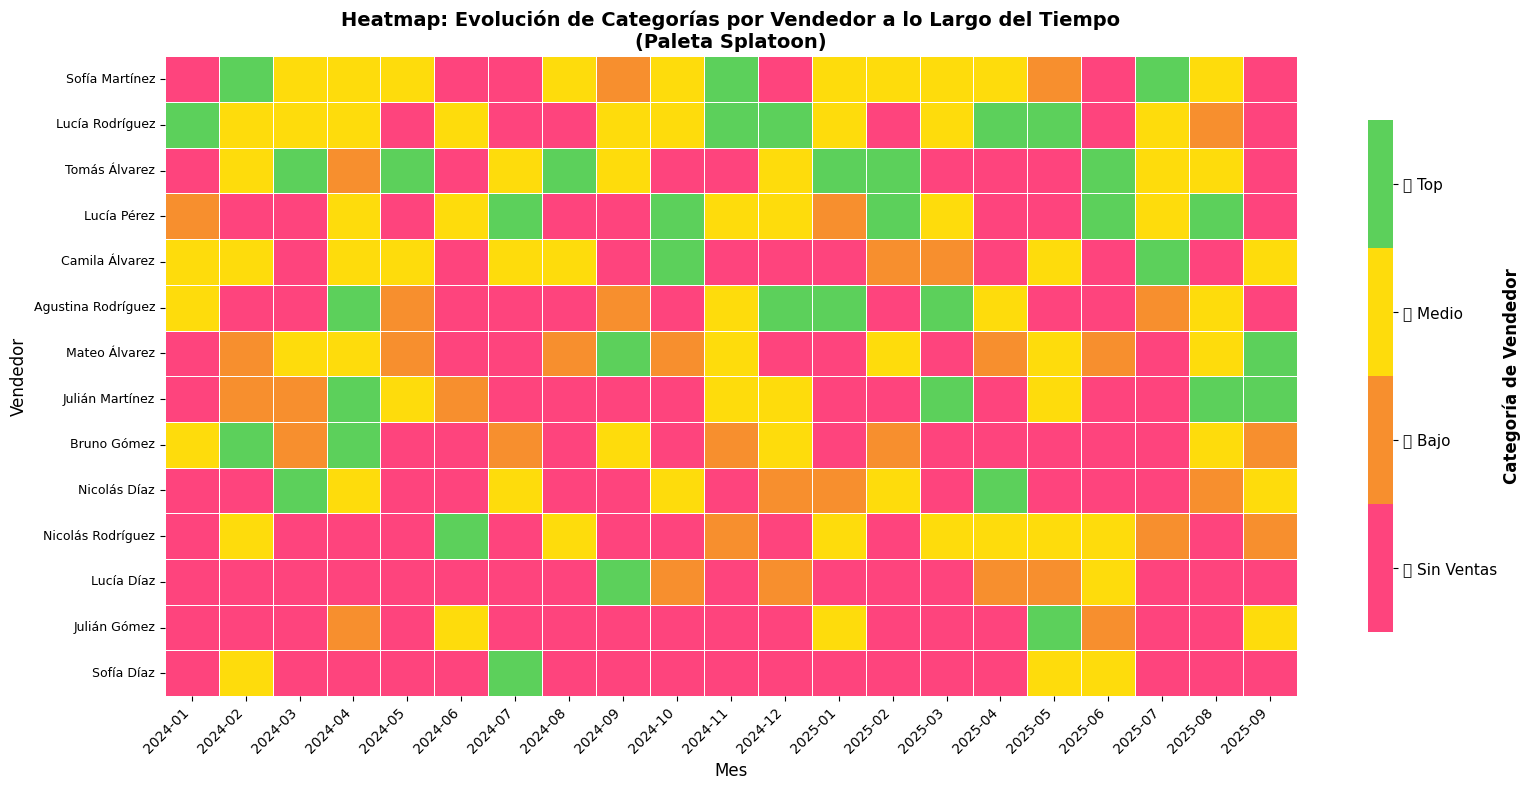


🔥 Interpretación del Heatmap (Paleta Splatoon):
• 🟢 Verde Esmeralda = Top (mejor 20% del mes)
• 🟡 Amarillo = Medio (40% del medio)
• 🟠 Naranja = Bajo (40% inferior)
• 🔴 Rosa = Sin ventas ese mes

Puedes ver cómo CADA VENDEDOR cambia de categoría mes a mes.
Recuerda: las categorías son RELATIVAS al desempeño de todos en ese mes.



In [14]:
# Gráfico 2: Mapa de calor mostrando la categoría de cada vendedor en cada mes
if HAS_SEABORN and len(vend_time_real) > 0:
    # Crear columna vendedor_nombre si no existe
    if 'vendedor_nombre' not in vend_time_real.columns:
        vend_time_real['vendedor_nombre'] = vend_time_real['nombre_vendedor'] + ' ' + vend_time_real['apellido_vendedor']
    
    # Crear dataset pivoteado: filas=vendedores, columnas=meses, valores=categoría
    # Mapear categorías a números para el heatmap
    cat_map = {'Top': 3, 'Medio': 2, 'Bajo': 1, 'SinVentas': 0}
    vend_time_real['cat_num'] = vend_time_real['categoria_vendedor'].map(cat_map)
    
    # Pivotear: un vendedor puede aparecer en múltiples meses con diferentes categorías
    # Tomamos la categoría más reciente (última) para cada combinación vendedor-mes
    vend_pivot = vend_time_real.pivot_table(
        index='vendedor_nombre',
        columns='mes',
        values='cat_num',
        aggfunc='first'  # Si hay duplicados, tomar el primero
    )
    
    # IMPORTANTE: Rellenar NaN con 0 (SinVentas) para que se visualicen en rosa
    vend_pivot = vend_pivot.fillna(0)
    
    # Ordenar vendedores por actividad total (suma de ventas)
    orden_vendedores = (
        vend_time_real.groupby('vendedor_nombre')['ventas']
        .sum()
        .sort_values(ascending=False)
        .index
    )
    vend_pivot = vend_pivot.reindex(orden_vendedores)
    
    # Heatmap con paleta Splatoon
    plt.figure(figsize=(16, 8))
    # Crear paleta personalizada: SinVentas(0), Bajo(1), Medio(2), Top(3)
    from matplotlib.colors import ListedColormap
    splatoon_cmap = ListedColormap([
        SPLATOON_COLORS['SinVentas'],  # 0: Pink
        SPLATOON_COLORS['Bajo'],       # 1: Orange
        SPLATOON_COLORS['Medio'],      # 2: Yellow
        SPLATOON_COLORS['Top']          # 3: Emerald Green
    ])
    
    ax_heatmap = sns.heatmap(
        vend_pivot,
        cmap=splatoon_cmap,
        cbar_kws={
            'label': 'Categoría de Vendedor',
            'ticks': [0.375, 1.125, 1.875, 2.625],  # Centrar en cada banda de color
            'shrink': 0.8
        },
        linewidths=0.5,
        linecolor='white',
        yticklabels=True,
        xticklabels=[col.strftime('%Y-%m') for col in vend_pivot.columns],
        vmin=0,
        vmax=3,
        cbar=True
    )
    
    # Personalizar colorbar con mejor visibilidad y labels correctos
    cbar = ax_heatmap.collections[0].colorbar
    cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
    cbar.set_ticklabels(['🔴 Sin Ventas', '🟠 Bajo', '🟡 Medio', '🟢 Top'])
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label('Categoría de Vendedor', fontsize=12, fontweight='bold')
    
    plt.title('Heatmap: Evolución de Categorías por Vendedor a lo Largo del Tiempo\n(Paleta Splatoon)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Mes', fontsize=12)
    plt.ylabel('Vendedor', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print("\n🔥 Interpretación del Heatmap (Paleta Splatoon):")
    print("• 🟢 Verde Esmeralda = Top (mejor 20% del mes)")
    print("• 🟡 Amarillo = Medio (40% del medio)")
    print("• 🟠 Naranja = Bajo (40% inferior)")
    print("• 🔴 Rosa = Sin ventas ese mes")
    print("\nPuedes ver cómo CADA VENDEDOR cambia de categoría mes a mes.")
    print("Recuerda: las categorías son RELATIVAS al desempeño de todos en ese mes.\n")
else:
    print("⚠️ Seaborn no disponible o no hay datos")


In [15]:
# Tabla: Ejemplo de cómo un vendedor cambia de categoría con las mismas ventas
print("="*80)
print("EJEMPLO: ¿Por qué un vendedor con 2 ventas puede ser Top en un mes y Medio en otro?")
print("="*80)

# Crear columna vendedor_nombre si no existe
if 'vendedor_nombre' not in vend_time_real.columns:
    vend_time_real['vendedor_nombre'] = vend_time_real['nombre_vendedor'] + ' ' + vend_time_real['apellido_vendedor']

# Buscar un vendedor que tenga ventas en al menos 3 meses
vendedores_multi_mes = vend_time_real.groupby('vendedor_nombre')['mes'].nunique()
vendedores_con_historial = vendedores_multi_mes[vendedores_multi_mes >= 3].index.tolist()

if len(vendedores_con_historial) > 0:
    # Tomar el primer vendedor con historial
    vendedor_ej = vendedores_con_historial[0]
    trayectoria = vend_time_real[vend_time_real['vendedor_nombre'] == vendedor_ej][
        ['mes', 'ventas', 'importe', 'categoria_vendedor']
    ].sort_values('mes')
    
    print(f"\n📊 Trayectoria de: {vendedor_ej}")
    print(trayectoria.to_string(index=False))
    
    print("\n💡 Explicación:")
    print("   Las categorías son RELATIVAS al desempeño de todos los vendedores en cada mes.")
    print("   Si todos venden mucho en un mes, tu 'promedio' te deja en categoría Bajo.")
    print("   Si todos venden poco, tu 'promedio' te pone en categoría Top.")
else:
    print("\n⚠️ No hay vendedores con historial de al menos 3 meses para mostrar ejemplo.")
    print("Mostrando primeros 10 registros de vend_time_real:")
    print(vend_time_real[['mes', 'nombre_vendedor', 'apellido_vendedor', 'ventas', 'importe', 'categoria_vendedor']].head(10).to_string(index=False))


EJEMPLO: ¿Por qué un vendedor con 2 ventas puede ser Top en un mes y Medio en otro?

📊 Trayectoria de: Agustina Rodríguez
       mes  ventas  importe categoria_vendedor
2024-01-01       2  4609.09              Medio
2024-04-01       2 10018.27                Top
2024-05-01       1   400.84               Bajo
2024-09-01       1  1286.94               Bajo
2024-11-01       1  2868.60              Medio
2024-12-01       1  4998.98                Top
2025-01-01       2  7055.93                Top
2025-03-01       5 16856.67                Top
2025-04-01       1  3108.99              Medio
2025-07-01       1   581.60               Bajo
2025-08-01       1  2807.37              Medio

💡 Explicación:
   Las categorías son RELATIVAS al desempeño de todos los vendedores en cada mes.
   Si todos venden mucho en un mes, tu 'promedio' te deja en categoría Bajo.
   Si todos venden poco, tu 'promedio' te pone en categoría Top.


## 5. 📊 Consultas de Negocio con Pandas

### Propósito: Demostrar equivalencia Pandas ↔ SQL

Este bloque tiene un **objetivo pedagógico**: demostrar que las operaciones analíticas típicas de SQL (`GROUP BY`, `JOIN`, `ORDER BY`, `MAX`) tienen equivalentes directos en Pandas.

**¿Por qué duplicar consultas en Pandas si ya existen en SQL?**

1. **Validación cruzada**: Verificar que ETL y modelo estrella son correctos — si Pandas y SQL dan diferentes resultados, hay un error de integridad.

2. **Exploración ágil**: Pandas permite iterar rápido (agregar columnas, filtros, visualizaciones) sin tocar la base de datos en producción.

3. **Portabilidad**: El código Pandas funciona en cualquier motor SQL (PostgreSQL, MySQL, SQLite) — solo cambia la query de extracción inicial.

4. **Prototipado de KPIs**: Antes de implementar una métrica en ETL/BI, probarla en Pandas permite ajustar la lógica sin impactar pipelines.

**Consultas implementadas:**
1. **Marca más vendida** — Top marcas por unidades, ventas (transacciones) e importe
2. **Vendedor con más ventas** — Vendedores top por importe, mostrando ventas, unidades y categoría
3. **Local con más ganancia** — Locales con mayor margen total y porcentual
4. **Método de pago más usado** — Distribución de transacciones por forma de pago
5. **Trimestre más alto/bajo** — Análisis temporal multimoneda con índice base 100

### 5.1 — Marca Más Vendida

Identifica la marca con mayor volumen de unidades vendidas. Muestra también número de ventas (transacciones) e importe total.

1. MARCA MÁS VENDIDA

Top 5 marcas por unidades vendidas:
      marca  ventas  unidades  importe_ars
0     Apple     105       229    246804.58
3   Samsung      90       193    100439.44
5    Xiaomi      84       187     73700.28
2  Motorola      68       149     68583.78
4       TCL      47       108     35975.20


C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\842863342.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_marcas, y='marca', x='unidades', ax=ax1, palette=colores_marcas[:len(top_marcas)], legend=False)
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\842863342.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_marcas, y='marca', x='importe_ars', ax=ax2, palette=colores_importe[:len(top_marcas)], legend=False)


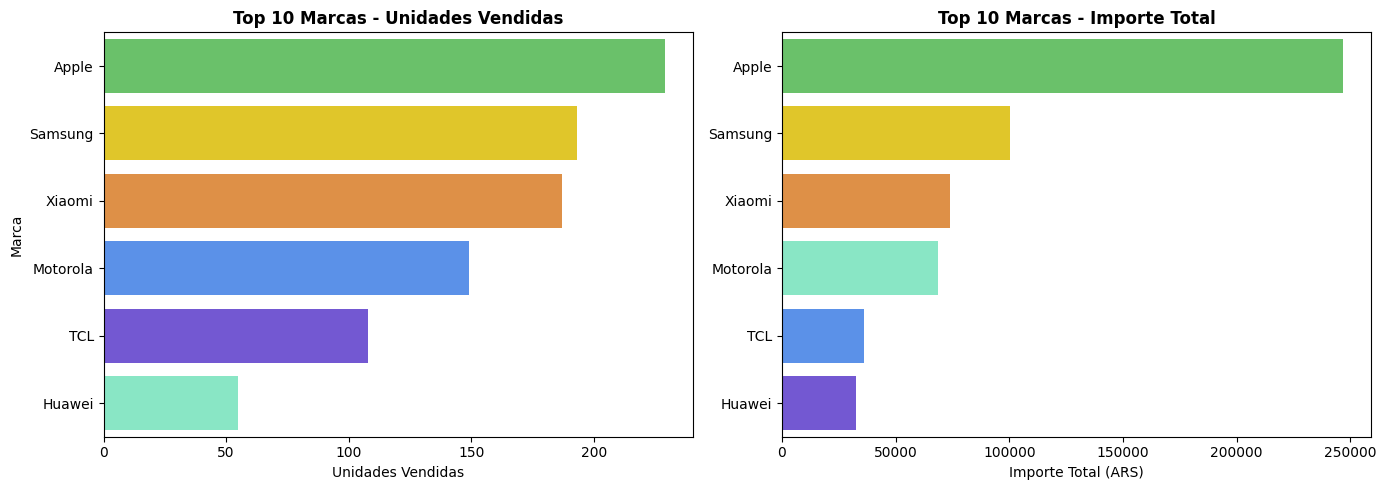

In [16]:
# 1️⃣ MARCA MÁS VENDIDA
print("="*60)
print("1. MARCA MÁS VENDIDA")
print("="*60)

# Agrupar por marca: ventas (transacciones únicas) + unidades (cantidad)
marca_ventas = (
    star.groupby('marca', as_index=False)
    .agg(
        ventas=('id_venta', 'nunique'),
        unidades=('cantidad', 'sum'),
        importe_ars=('importe', 'sum')
    )
    .sort_values('unidades', ascending=False)
)

print("\nTop 5 marcas por unidades vendidas:")
print(marca_ventas.head())

# Gráfico
if HAS_SEABORN:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico 1: Unidades por marca (paleta Splatoon)
    top_marcas = marca_ventas.head(10)
    colores_marcas = [SPLATOON_COLORS['Top'], SPLATOON_COLORS['Medio'], SPLATOON_COLORS['Bajo'], 
                      SPLATOON_COLORS['extra1'], SPLATOON_COLORS['extra2'], SPLATOON_COLORS['extra3'],
                      SPLATOON_COLORS['extra1'], SPLATOON_COLORS['extra2'], SPLATOON_COLORS['extra3'], SPLATOON_COLORS['extra4']]
    sns.barplot(data=top_marcas, y='marca', x='unidades', ax=ax1, palette=colores_marcas[:len(top_marcas)], legend=False)
    ax1.set_title('Top 10 Marcas - Unidades Vendidas', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Unidades Vendidas')
    ax1.set_ylabel('Marca')
    
    # Gráfico 2: Importe por marca (paleta Splatoon degradada)
    colores_importe = [SPLATOON_COLORS['Top'], SPLATOON_COLORS['Medio'], SPLATOON_COLORS['Bajo'],
                       SPLATOON_COLORS['extra3'], SPLATOON_COLORS['extra1'], SPLATOON_COLORS['extra2'],
                       SPLATOON_COLORS['extra4'], '#7af5ca', '#448bff', '#6844E6']
    sns.barplot(data=top_marcas, y='marca', x='importe_ars', ax=ax2, palette=colores_importe[:len(top_marcas)], legend=False)
    ax2.set_title('Top 10 Marcas - Importe Total', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Importe Total (ARS)')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Seaborn no disponible, solo se muestra la tabla")

### 5.2 — Vendedor con Más Ventas

Identifica los vendedores con mayor importe facturado. Muestra ventas (transacciones), unidades vendidas y categoría (Top/Medio/Bajo).

2. VENDEDOR CON MÁS VENTAS (por importe histórico)

Top 10 vendedores por facturación histórica:
     vendedor_completo categoria_vendedor  ventas  unidades  importe_ars
12      Sofía Martínez                Top      28       121     75913.35
7      Lucía Rodríguez                Top      24        93     61407.98
13       Tomás Álvarez                Top      21       100     60399.06
0   Agustina Rodríguez              Medio      18        87     54593.28
6          Lucía Pérez              Medio      20        93     52041.10
4      Julián Martínez              Medio      15        63     44061.22
2       Camila Álvarez               Bajo      19        71     39216.15
8        Mateo Álvarez               Bajo      17        62     37897.10
9         Nicolás Díaz               Bajo      14        57     32087.08
1          Bruno Gómez               Bajo      14        54     28757.52


C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\2649033071.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vendedores, y='vendedor_completo', x='ventas',
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\2649033071.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_vendedores, y='vendedor_completo', x='importe_ars',


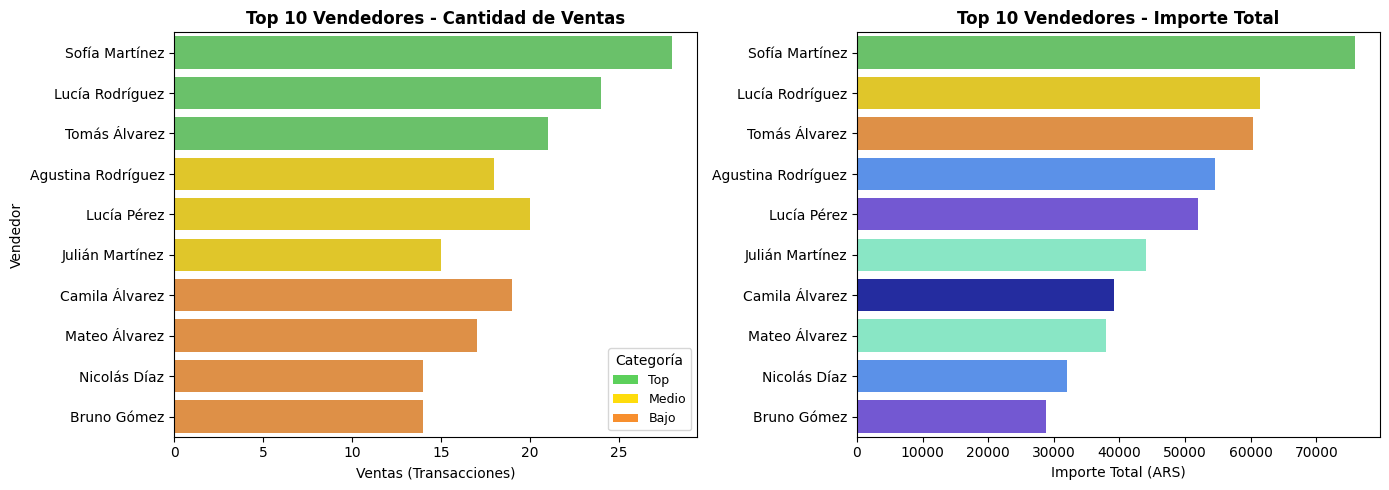

In [17]:
# 2️⃣ VENDEDOR CON MÁS VENTAS (Histórico Acumulado)
print("="*60)
print("2. VENDEDOR CON MÁS VENTAS (por importe histórico)")
print("="*60)

# Agrupar por vendedor - análisis histórico completo
vendedor_ventas = (
    star[star['id_vendedor_fuente'] > 0]
    .groupby(['nombre_vendedor', 'apellido_vendedor', 'categoria_vendedor'], as_index=False)
    .agg(
        ventas=('id_venta', 'nunique'),
        unidades=('cantidad', 'sum'),
        importe_ars=('importe', 'sum')
    )
    .sort_values('importe_ars', ascending=False)
)

# Recategorización automática si todo aparece como "Inicial"
if vendedor_ventas['categoria_vendedor'].nunique() == 1 and 'Inicial' in vendedor_ventas['categoria_vendedor'].values:
    # Calcular percentiles para recategorizar
    q80 = vendedor_ventas['importe_ars'].quantile(0.8)
    q60 = vendedor_ventas['importe_ars'].quantile(0.6) 
    q20 = vendedor_ventas['importe_ars'].quantile(0.2)
    
    # Aplicar nueva categorización
    def categorizar_vendedor(importe):
        if importe >= q80:
            return 'Top'
        elif importe >= q60:
            return 'Medio'
        elif importe >= q20:
            return 'Bajo'
        else:
            return 'SinVentas'
    
    vendedor_ventas['categoria_vendedor'] = vendedor_ventas['importe_ars'].apply(categorizar_vendedor)

vendedor_ventas['vendedor_completo'] = vendedor_ventas['nombre_vendedor'] + ' ' + vendedor_ventas['apellido_vendedor']

print("\nTop 10 vendedores por facturación histórica:")
print(vendedor_ventas[['vendedor_completo', 'categoria_vendedor', 'ventas', 'unidades', 'importe_ars']].head(10))

# Gráficos
if HAS_SEABORN:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    top_vendedores = vendedor_ventas.head(10)
    
    # Gráfico 1: Ventas por vendedor con colores por categoría
    cat_colors = top_vendedores['categoria_vendedor'].map(lambda c: SPLATOON_COLORS.get(c, '#808080')).tolist()
    sns.barplot(data=top_vendedores, y='vendedor_completo', x='ventas', 
                ax=ax1, palette=cat_colors, legend=False)
    ax1.set_title('Top 10 Vendedores - Cantidad de Ventas', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Ventas (Transacciones)')
    ax1.set_ylabel('Vendedor')
    
    # Leyenda de categorías
    from matplotlib.patches import Patch
    unique_cats = top_vendedores['categoria_vendedor'].unique()
    legend_elements = [Patch(facecolor=SPLATOON_COLORS.get(cat, '#808080'), label=cat) for cat in unique_cats]
    ax1.legend(handles=legend_elements, title='Categoría', loc='lower right', fontsize=9)
    
    # Gráfico 2: Importe por vendedor
    colores_vendedores = [SPLATOON_COLORS['Top'], SPLATOON_COLORS['Medio'], SPLATOON_COLORS['Bajo'],
                          SPLATOON_COLORS['extra1'], SPLATOON_COLORS['extra2'], SPLATOON_COLORS['extra3'],
                          SPLATOON_COLORS['extra4'], '#7af5ca', '#448bff', '#6844E6']
    sns.barplot(data=top_vendedores, y='vendedor_completo', x='importe_ars', 
                ax=ax2, palette=colores_vendedores[:len(top_vendedores)], legend=False)
    ax2.set_title('Top 10 Vendedores - Importe Total', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Importe Total (ARS)')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Seaborn no disponible, solo se muestra la tabla")

### 5.3 — Local con Más Ganancia

Identifica los locales con mayor margen de ganancia total. Muestra ventas (transacciones), importe y margen en ARS.

3. LOCAL CON MÁS GANANCIA

Top 10 locales por margen:
                        local_completo     provincia  ventas  importe_ars  \
6        Sucursal Centro MEN (Mendoza)       Mendoza      23     65118.41   
4        Sucursal Centro CÓR (Córdoba)       Córdoba      22     60924.56   
10       Sucursal Centro ROS (Rosario)      Santa Fe      20     59099.98   
11        Sucursal Norte ROS (Rosario)      Santa Fe      16     51508.97   
5         Sucursal Norte CÓR (Córdoba)       Córdoba      20     46296.70   
1    Sucursal Norte BUE (Buenos Aires)  Buenos Aires      19     45760.02   
9        Sucursal Norte SAN (San Luis)      San Luis      20     47106.10   
8       Sucursal Centro SAN (San Luis)      San Luis      20     44070.70   
0   Sucursal Centro BUE (Buenos Aires)  Buenos Aires      16     39385.86   
7         Sucursal Norte MEN (Mendoza)       Mendoza      16     39225.56   

    margen_ars  
6     19810.04  
4     18617.42  
10    16805.54  
11    16554.82  
5     14537.6

C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\2517209244.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_locales, y='local_completo', x='margen_ars', ax=ax1, palette=colores_locales[:len(top_locales)], legend=False)
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\2517209244.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_locales, y='local_completo', x='importe_ars', ax=ax2, palette=colores_importe_local[:len(top_locales)], legend=False)


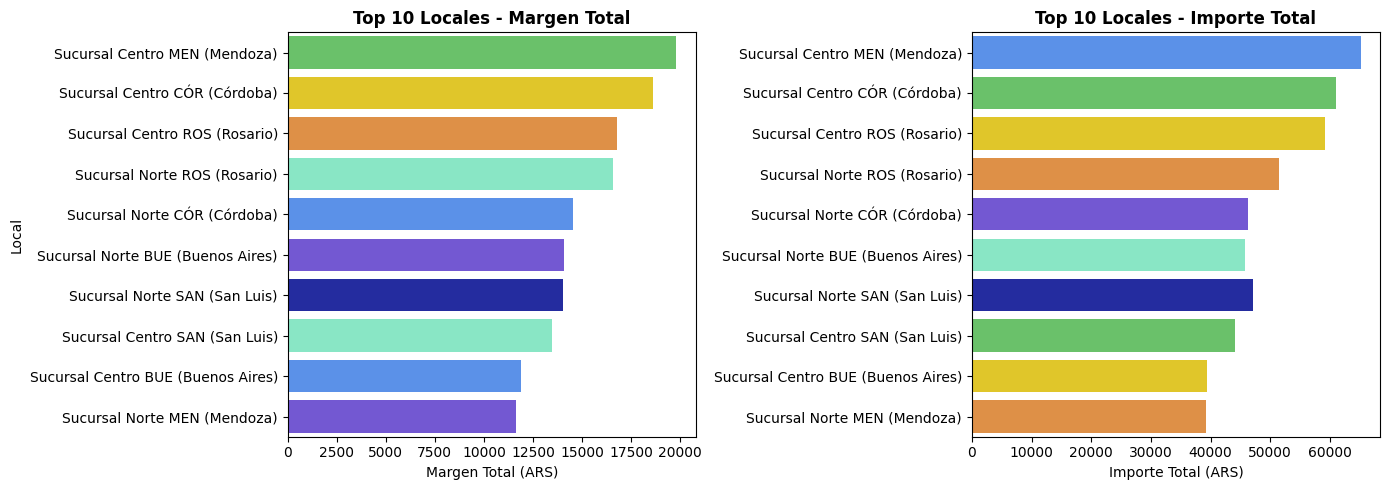

In [18]:
# 3️⃣ LOCAL CON MÁS GANANCIA
print("="*60)
print("3. LOCAL CON MÁS GANANCIA")
print("="*60)

# Agrupar por local (como SQL)
local_ganancia = (
    star.groupby(['provincia', 'ciudad', 'local'], as_index=False)
    .agg(
        ventas=('id_venta', 'nunique'),
        importe_ars=('importe', 'sum'),
        margen_ars=('margen', 'sum')
    )
    .sort_values('margen_ars', ascending=False)
)

local_ganancia['local_completo'] = local_ganancia['local'] + ' (' + local_ganancia['ciudad'] + ')'

print("\nTop 10 locales por margen:")
print(local_ganancia[['local_completo', 'provincia', 'ventas', 'importe_ars', 'margen_ars']].head(10))

# Gráfico
if HAS_SEABORN:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    top_locales = local_ganancia.head(10)
    
    # Gráfico 1: Margen por local (paleta Splatoon)
    colores_locales = [SPLATOON_COLORS['Top'], SPLATOON_COLORS['Medio'], SPLATOON_COLORS['Bajo'],
                       SPLATOON_COLORS['extra3'], SPLATOON_COLORS['extra1'], SPLATOON_COLORS['extra2'],
                       SPLATOON_COLORS['extra4'], '#7af5ca', '#448bff', '#6844E6']
    sns.barplot(data=top_locales, y='local_completo', x='margen_ars', ax=ax1, palette=colores_locales[:len(top_locales)], legend=False)
    ax1.set_title('Top 10 Locales - Margen Total', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Margen Total (ARS)')
    ax1.set_ylabel('Local')
    
    # Gráfico 2: Importe por local (paleta Splatoon complementaria)
    colores_importe_local = [SPLATOON_COLORS['extra1'], SPLATOON_COLORS['Top'], SPLATOON_COLORS['Medio'],
                             SPLATOON_COLORS['Bajo'], SPLATOON_COLORS['extra2'], SPLATOON_COLORS['extra3'],
                             SPLATOON_COLORS['extra4'], '#5cd05b', '#fedc0c', '#f78f2e']
    sns.barplot(data=top_locales, y='local_completo', x='importe_ars', ax=ax2, palette=colores_importe_local[:len(top_locales)], legend=False)
    ax2.set_title('Top 10 Locales - Importe Total', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Importe Total (ARS)')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Seaborn no disponible, solo se muestra la tabla")

### 5.4 — Método de Pago Más Usado

Analiza la distribución de ventas por método de pago (Efectivo, Tarjeta de Crédito, Débito, Transferencia).

4. MÉTODO DE PAGO MÁS USADO (por transacciones)

Métodos de pago ordenados por transacciones:
        forma_pago  transacciones  importe_ars
4    Transferencia            107    132838.98
2  Tarjeta Crédito            104    116296.14
3   Tarjeta Débito             97    128272.15
1     Mercado Pago             83    106416.83
0         Efectivo             73     74426.99


C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\506258527.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=forma_pago_uso, x='forma_pago', y='importe_ars', ax=ax2, palette=colores_pago, legend=False)
C:\Users\Vespula\AppData\Local\Temp\ipykernel_24108\506258527.py:32: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=forma_pago_uso, x='forma_pago', y='importe_ars', ax=ax2, palette=colores_pago, legend=False)


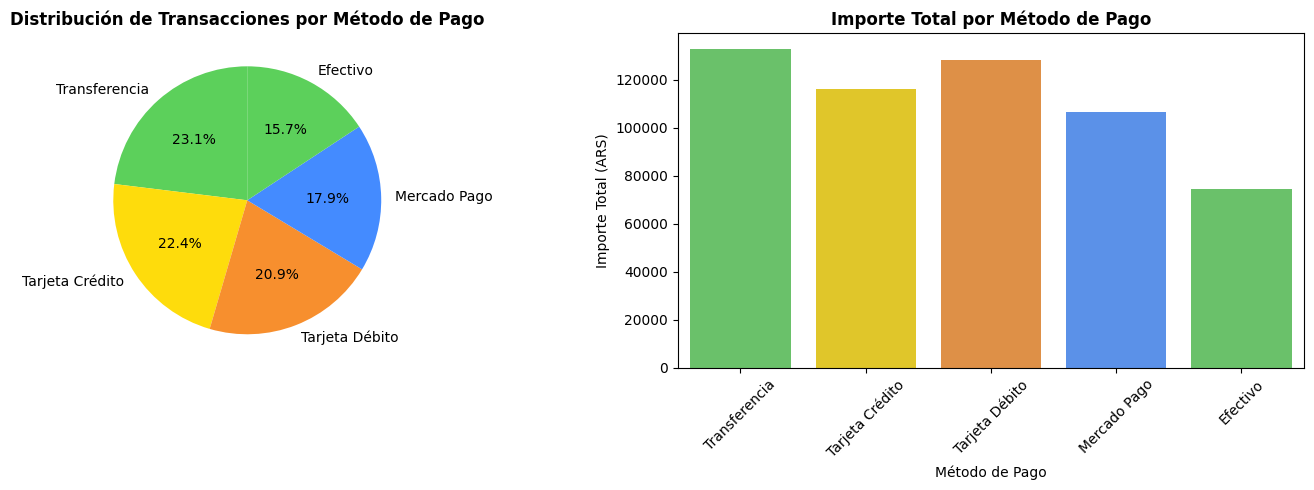

In [19]:
# 4️⃣ MÉTODO DE PAGO MÁS USADO
print("="*60)
print("4. MÉTODO DE PAGO MÁS USADO (por transacciones)")
print("="*60)

# Agrupar por forma de pago
# SQL usa COUNT(*) = número de filas/transacciones
forma_pago_uso = (
    star.groupby('forma_pago', as_index=False)
    .agg(
        transacciones=('id_detalle', 'count'),  # COUNT(*) en SQL
        importe_ars=('importe', 'sum')
    )
    .sort_values('transacciones', ascending=False)
)

print("\nMétodos de pago ordenados por transacciones:")
print(forma_pago_uso)

# Gráfico
if HAS_SEABORN:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico 1: Torta de distribución de transacciones (paleta Splatoon)
    colores_pago = [SPLATOON_COLORS['Top'], SPLATOON_COLORS['Medio'], 
                    SPLATOON_COLORS['Bajo'], SPLATOON_COLORS['extra1']][:len(forma_pago_uso)]
    ax1.pie(forma_pago_uso['transacciones'], labels=forma_pago_uso['forma_pago'], 
            autopct='%1.1f%%', startangle=90, colors=colores_pago)
    ax1.set_title('Distribución de Transacciones por Método de Pago', fontsize=12, fontweight='bold')
    
    # Gráfico 2: Barras de importe por método (paleta Splatoon)
    sns.barplot(data=forma_pago_uso, x='forma_pago', y='importe_ars', ax=ax2, palette=colores_pago, legend=False)
    ax2.set_title('Importe Total por Método de Pago', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Método de Pago')
    ax2.set_ylabel('Importe Total (ARS)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Seaborn no disponible, solo se muestra la tabla")

### 5.5 — Trimestre Más Alto y Más Bajo (Multimoneda)

Analiza las ventas trimestrales con índice base 100 para comparar el crecimiento real vs inflacionario en múltiples monedas (ARS, USD, EUR, BRL, CNY).

CONSULTA 5: TRIMESTRES MÁS ALTOS Y MÁS BAJOS
✓ Tipos de cambio cargados para 4 trimestres

✅ Trimestre más bajo: 4 → $82,267.75 ARS
✅ Trimestre más alto: 2 → $169,053.36 ARS

📊 TRIMESTRE MÁS BAJO (4):
   • ARS: $82,267.75
   • USD: $200.33
   • EUR: $184.51
   • BRL: $1,001.64
   • CNY: $1,402.29

📊 TRIMESTRE MÁS ALTO (2):
   • ARS: $169,053.36
   • USD: $437.11
   • EUR: $402.60
   • BRL: $2,185.56
   • CNY: $3,059.79

📊 Tabla Resumen: Facturación Trimestral Multimoneda
periodo  total_ventas  unidades  importe_ars  importe_usd  importe_eur  importe_brl  importe_cny
      1            62       270      160,287          426          392        2,130        2,982
      2            67       282      169,053          437          403        2,186        3,060
      3            59       243      146,643          368          339        1,838        2,573
      4            32       126       82,268          200          185        1,002        1,402
⚠️ NaN = Sin tipo de cambio disponible 

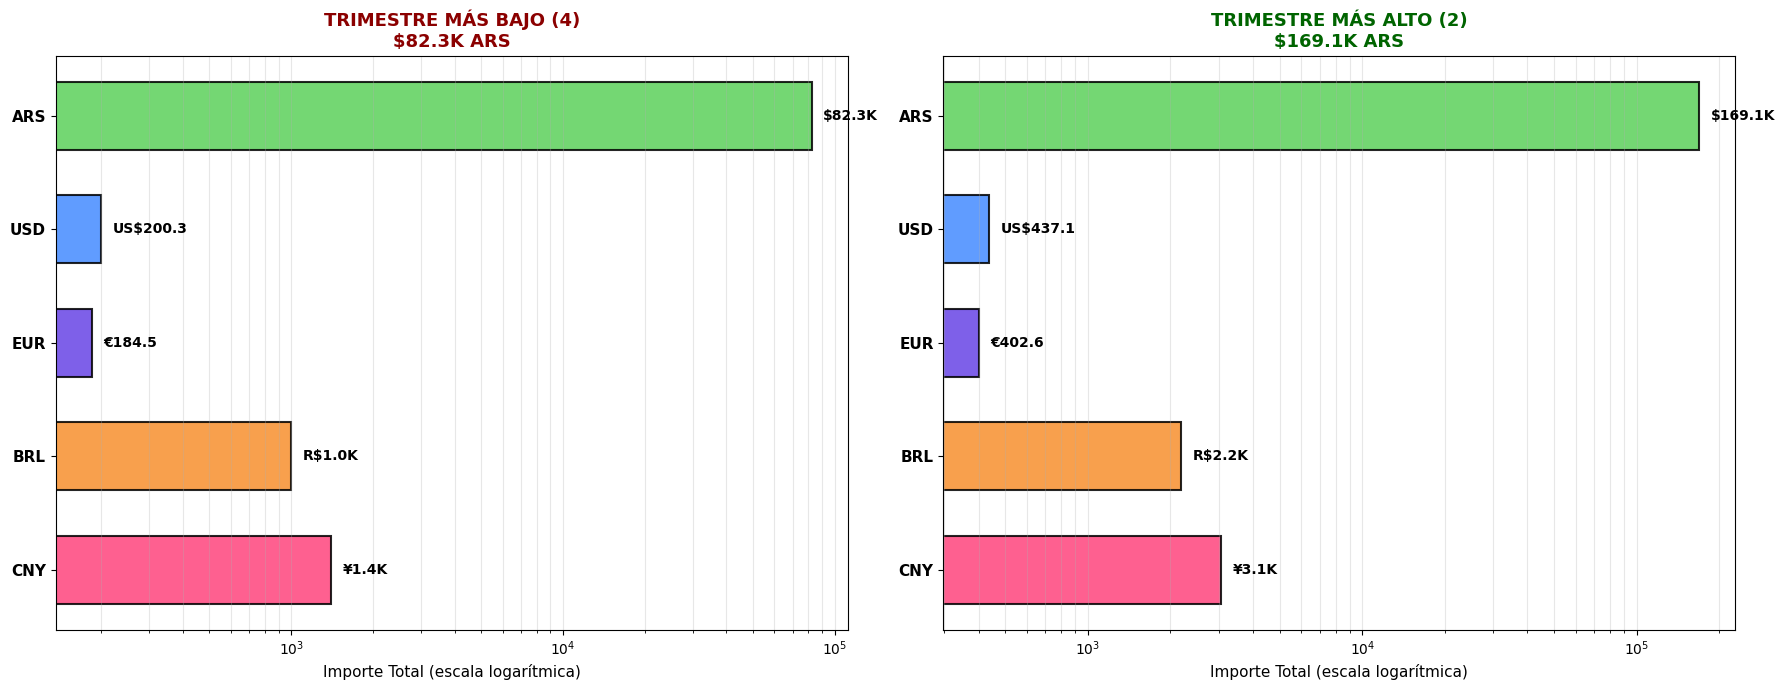

In [20]:
# Consulta 5: Trimestres con mayores y menores ventas (multimoneda)
print("="*60)
print("CONSULTA 5: TRIMESTRES MÁS ALTOS Y MÁS BAJOS")
print("="*60)

# Agrupar por trimestre
trimestre_ventas = (
    star.groupby('trimestre', as_index=False)
    .agg(
        total_ventas=('id_venta', 'nunique'),
        unidades=('cantidad', 'sum'),
        importe_ars=('importe', 'sum')
    )
    .sort_values('trimestre')
)

trimestre_ventas['periodo'] = trimestre_ventas['trimestre'].astype(str)

# Conversión multimoneda usando DimExchangeRate
tiene_multimoneda = False
if 'DimExchangeRate' in dfs and len(dfs['DimExchangeRate']) > 0:
    # CORRECCIÓN: Hacer match por año-mes-trimestre en lugar de fecha exacta
    exchange = dfs['DimExchangeRate'].copy()
    
    # Extraer año-mes de la fecha de tipos de cambio (primer día del mes)
    exchange['anio'] = pd.to_datetime(exchange['fecha']).dt.year
    exchange['mes'] = pd.to_datetime(exchange['fecha']).dt.month
    exchange['trimestre_tc'] = pd.to_datetime(exchange['fecha']).dt.quarter
    
    # Calcular tipos de cambio promedio por trimestre y moneda
    tc_trim = (
        exchange.groupby(['trimestre_tc', 'codigo_moneda'], as_index=False)['tasa_ars_por_unidad']
        .mean()
        .pivot(index='trimestre_tc', columns='codigo_moneda', values='tasa_ars_por_unidad')
    )
    
    if len(tc_trim) > 0:
        tc_trim.columns = ['tc_' + col.lower() for col in tc_trim.columns]
        # Merge usando el número de trimestre
        trimestre_ventas = trimestre_ventas.merge(tc_trim, left_on='trimestre', right_index=True, how='left')
        
        # Calcular importes en otras monedas
        for moneda in ['usd', 'eur', 'brl', 'cny']:
            col_tc = f'tc_{moneda}'
            col_importe = f'importe_{moneda}'
            if col_tc in trimestre_ventas.columns:
                trimestre_ventas[col_importe] = trimestre_ventas['importe_ars'] / trimestre_ventas[col_tc]
                tiene_multimoneda = True
        
        # Debug: mostrar merge exitoso
        print(f"✓ Tipos de cambio cargados para {len(tc_trim)} trimestres")

# Identificar trimestres más alto y más bajo
trimestre_bajo = trimestre_ventas.loc[trimestre_ventas['importe_ars'].idxmin()]
trimestre_alto = trimestre_ventas.loc[trimestre_ventas['importe_ars'].idxmax()]

trimestre_bajo_periodo = trimestre_bajo['periodo']
trimestre_bajo_importe = trimestre_bajo['importe_ars']
trimestre_alto_periodo = trimestre_alto['periodo']
trimestre_alto_importe = trimestre_alto['importe_ars']

print(f"\n✅ Trimestre más bajo: {trimestre_bajo_periodo} → ${trimestre_bajo_importe:,.2f} ARS")
print(f"✅ Trimestre más alto: {trimestre_alto_periodo} → ${trimestre_alto_importe:,.2f} ARS")

# Mostrar detalles del trimestre BAJO en todas las monedas
print(f"\n📊 TRIMESTRE MÁS BAJO ({trimestre_bajo_periodo}):")
print(f"   • ARS: ${trimestre_bajo['importe_ars']:,.2f}")
if 'importe_usd' in trimestre_bajo.index and pd.notna(trimestre_bajo['importe_usd']):
    print(f"   • USD: ${trimestre_bajo['importe_usd']:,.2f}")
if 'importe_eur' in trimestre_bajo.index and pd.notna(trimestre_bajo['importe_eur']):
    print(f"   • EUR: ${trimestre_bajo['importe_eur']:,.2f}")
if 'importe_brl' in trimestre_bajo.index and pd.notna(trimestre_bajo['importe_brl']):
    print(f"   • BRL: ${trimestre_bajo['importe_brl']:,.2f}")
if 'importe_cny' in trimestre_bajo.index and pd.notna(trimestre_bajo['importe_cny']):
    print(f"   • CNY: ${trimestre_bajo['importe_cny']:,.2f}")

# Mostrar detalles del trimestre ALTO en todas las monedas
print(f"\n📊 TRIMESTRE MÁS ALTO ({trimestre_alto_periodo}):")
print(f"   • ARS: ${trimestre_alto['importe_ars']:,.2f}")
if 'importe_usd' in trimestre_alto.index and pd.notna(trimestre_alto['importe_usd']):
    print(f"   • USD: ${trimestre_alto['importe_usd']:,.2f}")
else:
    print(f"   • USD: N/A (sin tipo de cambio)")
if 'importe_eur' in trimestre_alto.index and pd.notna(trimestre_alto['importe_eur']):
    print(f"   • EUR: ${trimestre_alto['importe_eur']:,.2f}")
else:
    print(f"   • EUR: N/A (sin tipo de cambio)")
if 'importe_brl' in trimestre_alto.index and pd.notna(trimestre_alto['importe_brl']):
    print(f"   • BRL: ${trimestre_alto['importe_brl']:,.2f}")
else:
    print(f"   • BRL: N/A (sin tipo de cambio)")
if 'importe_cny' in trimestre_alto.index and pd.notna(trimestre_alto['importe_cny']):
    print(f"   • CNY: ${trimestre_alto['importe_cny']:,.2f}")
else:
    print(f"   • CNY: N/A (sin tipo de cambio)")

# Mostrar tabla resumen completa
if tiene_multimoneda:
    print("\n📊 Tabla Resumen: Facturación Trimestral Multimoneda")
    print("=" * 140)
    cols_mostrar = ['periodo', 'total_ventas', 'unidades', 'importe_ars']
    if 'importe_usd' in trimestre_ventas.columns:
        cols_mostrar.append('importe_usd')
    if 'importe_eur' in trimestre_ventas.columns:
        cols_mostrar.append('importe_eur')
    if 'importe_brl' in trimestre_ventas.columns:
        cols_mostrar.append('importe_brl')
    if 'importe_cny' in trimestre_ventas.columns:
        cols_mostrar.append('importe_cny')
    
    tabla_display = trimestre_ventas[cols_mostrar].copy()
    print(tabla_display.to_string(index=False, float_format=lambda x: f'{x:,.0f}'))
    print("=" * 140)
    print("⚠️ NaN = Sin tipo de cambio disponible para ese trimestre")

# Gráficos de facturación trimestral: un gráfico por trimestre (BAJO y ALTO)
# Usando barras horizontales con escala logarítmica para apreciar todas las monedas
if HAS_SEABORN:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Preparar datos del trimestre BAJO
    trimestre_bajo_row = trimestre_ventas[trimestre_ventas['periodo'] == trimestre_bajo_periodo].iloc[0]
    
    # GRÁFICO 1: TRIMESTRE MÁS BAJO - Todas las monedas (BARRAS HORIZONTALES)
    if tiene_multimoneda and 'importe_usd' in trimestre_ventas.columns:
        # Datos del trimestre bajo (invertir orden para que ARS quede arriba)
        monedas_bajo = []
        valores_bajo = []
        colores_bajo = []
        
        # CNY (va al final para quedar abajo)
        if 'importe_cny' in trimestre_bajo_row.index:
            val_cny = trimestre_bajo_row['importe_cny'] if pd.notna(trimestre_bajo_row['importe_cny']) else 0.01
            monedas_bajo.append('CNY')
            valores_bajo.append(val_cny)
            colores_bajo.append(SPLATOON_COLORS['SinVentas'])
        
        # BRL
        if 'importe_brl' in trimestre_bajo_row.index:
            val_brl = trimestre_bajo_row['importe_brl'] if pd.notna(trimestre_bajo_row['importe_brl']) else 0.01
            monedas_bajo.append('BRL')
            valores_bajo.append(val_brl)
            colores_bajo.append(SPLATOON_COLORS['Bajo'])
        
        # EUR
        if 'importe_eur' in trimestre_bajo_row.index:
            val_eur = trimestre_bajo_row['importe_eur'] if pd.notna(trimestre_bajo_row['importe_eur']) else 0.01
            monedas_bajo.append('EUR')
            valores_bajo.append(val_eur)
            colores_bajo.append(SPLATOON_COLORS['extra2'])
        
        # USD
        if 'importe_usd' in trimestre_bajo_row.index:
            val_usd = trimestre_bajo_row['importe_usd'] if pd.notna(trimestre_bajo_row['importe_usd']) else 0.01
            monedas_bajo.append('USD')
            valores_bajo.append(val_usd)
            colores_bajo.append(SPLATOON_COLORS['extra1'])
        
        # ARS (va al principio para quedar arriba)
        monedas_bajo.append('ARS')
        valores_bajo.append(trimestre_bajo_row['importe_ars'])
        colores_bajo.append(SPLATOON_COLORS['Top'])
        
        # Crear barras HORIZONTALES con escala logarítmica
        y_pos = np.arange(len(monedas_bajo))
        bars1 = ax1.barh(y_pos, valores_bajo, color=colores_bajo, alpha=0.85, edgecolor='black', linewidth=1.5, height=0.6)
        
        # Configurar escala logarítmica en X
        ax1.set_xscale('log')
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(monedas_bajo, fontsize=11, fontweight='bold')
        
        # Anotaciones a la derecha de cada barra con símbolos de moneda correctos
        simbolos = {'ARS': '$', 'USD': 'US$', 'EUR': '€', 'BRL': 'R$', 'CNY': '¥'}
        for i, (moneda, val) in enumerate(zip(monedas_bajo, valores_bajo)):
            if val > 0.01:
                simbolo = simbolos.get(moneda, '$')
                if moneda == 'ARS':
                    texto = f"{simbolo}{val/1e6:.2f}M" if val >= 1e6 else f"{simbolo}{val/1e3:.1f}K"
                else:
                    texto = f"{simbolo}{val/1e3:.1f}K" if val >= 1e3 else f"{simbolo}{val:.1f}"
                ax1.text(val * 1.1, i, texto, ha='left', va='center', fontsize=10, fontweight='bold')
            else:
                ax1.text(1, i, 'N/A', ha='left', va='center', fontsize=9, style='italic', alpha=0.6)
        
        ax1.set_title(f'TRIMESTRE MÁS BAJO ({trimestre_bajo_periodo})\n${trimestre_bajo_importe/1e3:.1f}K ARS', 
                     fontsize=13, fontweight='bold', color='darkred')
        ax1.set_xlabel('Importe Total (escala logarítmica)', fontsize=11)
        ax1.grid(True, alpha=0.3, axis='x', which='both')
    else:
        # Solo ARS si no hay multimoneda
        ax1.barh([0], [trimestre_bajo_row['importe_ars']], color=SPLATOON_COLORS['Top'], 
               alpha=0.85, edgecolor='black', linewidth=1.5, height=0.4)
        ax1.set_yticks([0])
        ax1.set_yticklabels(['ARS'])
        ax1.set_title(f'TRIMESTRE MÁS BAJO ({trimestre_bajo_periodo})', fontsize=13, fontweight='bold')
        ax1.text(trimestre_bajo_row['importe_ars'] * 1.05, 0, f"${trimestre_bajo_row['importe_ars']/1e3:.1f}K", 
                ha='left', va='center', fontsize=10, fontweight='bold')
    
    # GRÁFICO 2: TRIMESTRE MÁS ALTO - Todas las monedas (BARRAS HORIZONTALES)
    trimestre_alto_row = trimestre_ventas[trimestre_ventas['periodo'] == trimestre_alto_periodo].iloc[0]
    
    if tiene_multimoneda and 'importe_usd' in trimestre_ventas.columns:
        # Datos del trimestre alto (invertir orden para que ARS quede arriba)
        monedas_alto = []
        valores_alto = []
        colores_alto = []
        
        # CNY (va al final para quedar abajo)
        if 'importe_cny' in trimestre_alto_row.index:
            val_cny = trimestre_alto_row['importe_cny'] if pd.notna(trimestre_alto_row['importe_cny']) else 0.01
            monedas_alto.append('CNY')
            valores_alto.append(val_cny)
            colores_alto.append(SPLATOON_COLORS['SinVentas'])
        
        # BRL
        if 'importe_brl' in trimestre_alto_row.index:
            val_brl = trimestre_alto_row['importe_brl'] if pd.notna(trimestre_alto_row['importe_brl']) else 0.01
            monedas_alto.append('BRL')
            valores_alto.append(val_brl)
            colores_alto.append(SPLATOON_COLORS['Bajo'])
        
        # EUR
        if 'importe_eur' in trimestre_alto_row.index:
            val_eur = trimestre_alto_row['importe_eur'] if pd.notna(trimestre_alto_row['importe_eur']) else 0.01
            monedas_alto.append('EUR')
            valores_alto.append(val_eur)
            colores_alto.append(SPLATOON_COLORS['extra2'])
        
        # USD
        if 'importe_usd' in trimestre_alto_row.index:
            val_usd = trimestre_alto_row['importe_usd'] if pd.notna(trimestre_alto_row['importe_usd']) else 0.01
            monedas_alto.append('USD')
            valores_alto.append(val_usd)
            colores_alto.append(SPLATOON_COLORS['extra1'])
        
        # ARS (va al principio para quedar arriba)
        monedas_alto.append('ARS')
        valores_alto.append(trimestre_alto_row['importe_ars'])
        colores_alto.append(SPLATOON_COLORS['Top'])
        
        # Crear barras HORIZONTALES con escala logarítmica
        y_pos = np.arange(len(monedas_alto))
        bars2 = ax2.barh(y_pos, valores_alto, color=colores_alto, alpha=0.85, edgecolor='black', linewidth=1.5, height=0.6)
        
        # Configurar escala logarítmica en X
        ax2.set_xscale('log')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(monedas_alto, fontsize=11, fontweight='bold')
        
        # Anotaciones a la derecha de cada barra con símbolos de moneda correctos
        simbolos = {'ARS': '$', 'USD': 'US$', 'EUR': '€', 'BRL': 'R$', 'CNY': '¥'}
        for i, (moneda, val) in enumerate(zip(monedas_alto, valores_alto)):
            if val > 0.01:
                simbolo = simbolos.get(moneda, '$')
                if moneda == 'ARS':
                    texto = f"{simbolo}{val/1e6:.2f}M" if val >= 1e6 else f"{simbolo}{val/1e3:.1f}K"
                else:
                    texto = f"{simbolo}{val/1e3:.1f}K" if val >= 1e3 else f"{simbolo}{val:.1f}"
                ax2.text(val * 1.1, i, texto, ha='left', va='center', fontsize=10, fontweight='bold')
            else:
                ax2.text(1, i, 'N/A', ha='left', va='center', fontsize=9, style='italic', alpha=0.6)
        
        ax2.set_title(f'TRIMESTRE MÁS ALTO ({trimestre_alto_periodo})\n${trimestre_alto_importe/1e3:.1f}K ARS', 
                     fontsize=13, fontweight='bold', color='darkgreen')
        ax2.set_xlabel('Importe Total (escala logarítmica)', fontsize=11)
        ax2.grid(True, alpha=0.3, axis='x', which='both')
    else:
        # Solo ARS si no hay multimoneda
        ax2.barh([0], [trimestre_alto_row['importe_ars']], color=SPLATOON_COLORS['Top'], 
               alpha=0.85, edgecolor='black', linewidth=1.5, height=0.4)
        ax2.set_yticks([0])
        ax2.set_yticklabels(['ARS'])
        ax2.set_title(f'TRIMESTRE MÁS ALTO ({trimestre_alto_periodo})', fontsize=13, fontweight='bold')
        ax2.text(trimestre_alto_row['importe_ars'] * 1.05, 0, f"${trimestre_alto_row['importe_ars']/1e3:.1f}K", 
                ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    

else:
    print("\n⚠️ Matplotlib/Seaborn no disponible")

### 🎓 Conceptos de Data Warehousing Aplicados

#### ¿Por qué Kimball (no Inmon)?
- **Kimball** (dimensional): Optimizado para consultas BI, denormalizado, fácil de entender por usuarios de negocio
- **Inmon** (normalizado): Orientado a integración de datos, más complejo para queries analíticas

Este proyecto usa Kimball porque el objetivo es **reporting y análisis**, no consolidación de múltiples OLTP corporativos.

#### ¿Por qué Surrogate Keys (sk_*)?
1. **Independencia del OLTP**: Si cliente_id cambia en el sistema fuente, sk_cliente permanece estable
2. **SCD Tipo 2**: Un mismo cliente puede tener múltiples sk (versiones históricas)
3. **Performance**: Enteros pequeños (4 bytes) vs strings largos (50+ bytes) como PK

#### ¿Por qué Unknown (SK=-1) en vez de NULL?
- NULL en FK rompe análisis GROUP BY (aparecen como valores omitidos)
- SK=-1 permite contar "Ventas con cliente desconocido" como categoría analítica válida

#### ¿Por qué métricas en FactVentas (no calculadas en queries)?
- **Principio de atomicidad**: Las facts deben almacenar el **grano más bajo** de medición (venta individual)
- `margen_porcentaje` es aditivo (sum, avg válidos) → pertenece a la fact
- Si fuera calculado on-the-fly, diferentes analistas podrían usar fórmulas inconsistentes